# 数据预处理

一、创建master栅格用于对齐数据


操作逻辑：
1、tif先无脑转换为.nc格式，尽量使用xarray的功能
2、空间范围一致：lat,lon经纬度一致
3、分辨率一致
4、坐标系一致
5、栅格对齐
6、栅格空洞

气象类数据检查（都来自于同一源）

找到 7 个.nc文件

文件名: pr_W5E5v1.0_20110101-20161231.nc

基本信息:
维度: ['lon', 'lat', 'time']
变量: ['pr']
坐标: ['lon', 'lat', 'time']

纬度范围: -89.75 到 89.75
纬度分辨率: 0.5°
经度范围: -179.75 到 179.75
经度分辨率: 0.5°

时间范围: 2011-01-01T00:00:00.000000000 到 2016-12-31T00:00:00.000000000
时间步长: 2192 步

变量分辨率:
变量 pr:
  - time 维度大小: 2192
  - lat 维度大小: 360
  - lon 维度大小: 720

详细信息:
xarray.Dataset {
dimensions:
	lon = 720 ;
	lat = 360 ;
	time = 2192 ;

variables:
	float64 lon(lon) ;
		lon:standard_name = longitude ;
		lon:long_name = Longitude ;
		lon:units = degrees_east ;
		lon:axis = X ;
	float64 lat(lat) ;
		lat:standard_name = latitude ;
		lat:long_name = Latitude ;
		lat:units = degrees_north ;
		lat:axis = Y ;
	datetime64[ns] time(time) ;
		time:standard_name = time ;
		time:long_name = Time ;
		time:axis = T ;
	float32 pr(time, lat, lon) ;
		pr:standard_name = precipitation_flux ;
		pr:long_name = Precipitation ;
		pr:units = kg m-2 s-1 ;

// global attributes:
	:Conventions = CF-1.7 ;
	:title = WFDE5 over land

In [4]:
import requests
import os
from tqdm import tqdm
import time
from datetime import datetime

def download_chelsa_rsds(start_year=2000, end_year=2019, output_dir='D:/xarray/chelsa_rsds'):
    """
    下载CHELSA辐射数据
    
    参数:
    start_year: 开始年份
    end_year: 结束年份
    output_dir: 输出目录
    """
    # 创建输出目录
    os.makedirs(output_dir, exist_ok=True)
    
    # 基础URL
    base_url = "https://os.zhdk.cloud.switch.ch/chelsav2/GLOBAL/monthly/rsds/CHELSA_rsds_{year}_{month:02d}_V.2.1.tif"
    
    # 下载函数
    def download_file(url, output_path):
        try:
            # 发送HEAD请求检查文件是否存在
            head = requests.head(url)
            if head.status_code != 200:
                print(f"文件不存在: {url}")
                return False
            
            # 发送GET请求下载文件
            response = requests.get(url, stream=True)
            response.raise_for_status()
            
            # 获取文件大小
            total_size = int(response.headers.get('content-length', 0))
            
            # 使用tqdm显示下载进度
            with open(output_path, 'wb') as f, tqdm(
                desc=os.path.basename(output_path),
                total=total_size,
                unit='iB',
                unit_scale=True
            ) as pbar:
                for data in response.iter_content(chunk_size=1024):
                    size = f.write(data)
                    pbar.update(size)
            return True
            
        except requests.exceptions.RequestException as e:
            print(f"下载出错: {url}")
            print(f"错误信息: {str(e)}")
            return False
    
    # 计算总文件数
    total_files = (end_year - start_year + 1) * 12
    processed_files = 0
    
    # 使用tqdm创建总体进度条
    with tqdm(total=total_files, desc="总体进度", unit="文件") as total_pbar:
        # 下载所有年份和月份的数据
        for year in range(start_year, end_year + 1):
            for month in range(1, 13):
                # 构建URL和输出路径
                url = base_url.format(year=year, month=month)
                output_path = os.path.join(output_dir, f"CHELSA_rsds_{year}_{month:02d}_V.2.1.tif")
                
                # 如果文件已存在，跳过下载
                if os.path.exists(output_path):
                    print(f"文件已存在，跳过: {output_path}")
                    processed_files += 1
                    total_pbar.update(1)
                    continue
                
                print(f"\n下载: {year}年{month}月")
                success = download_file(url, output_path)
                
                if success:
                    print(f"成功下载: {output_path}")
                else:
                    print(f"下载失败: {url}")
                
                processed_files += 1
                total_pbar.update(1)
                
                # 添加延时，避免请求过于频繁
                time.sleep(1)
    
    print(f"\n下载完成！共处理 {processed_files}/{total_files} 个文件")

# 使用示例
if __name__ == "__main__":
    # 设置下载参数
    start_year = 2000
    end_year = 2019
    output_dir = r'D:\xarray\pre-process\Climate'
    
    # 开始下载
    download_chelsa_rsds(start_year, end_year, output_dir)

CHELSA_rsds_2001_08_V.2.1.tif: 100%|██████████| 429M/429M [01:11<00:00, 5.96MiB/s]
总体进度:   8%|▊         | 20/240 [20:37<3:47:28, 62.04s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2001_08_V.2.1.tif

下载: 2001年9月


CHELSA_rsds_2001_09_V.2.1.tif: 100%|██████████| 464M/464M [01:05<00:00, 7.03MiB/s]
总体进度:   9%|▉         | 21/240 [21:47<3:54:45, 64.32s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2001_09_V.2.1.tif

下载: 2001年10月


CHELSA_rsds_2001_10_V.2.1.tif: 100%|██████████| 474M/474M [01:10<00:00, 6.72MiB/s]
总体进度:   9%|▉         | 22/240 [23:01<4:04:29, 67.29s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2001_10_V.2.1.tif

下载: 2001年11月


CHELSA_rsds_2001_11_V.2.1.tif: 100%|██████████| 446M/446M [00:50<00:00, 8.76MiB/s]
总体进度:  10%|▉         | 23/240 [23:55<3:49:18, 63.40s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2001_11_V.2.1.tif

下载: 2001年12月


CHELSA_rsds_2001_12_V.2.1.tif: 100%|██████████| 423M/423M [01:02<00:00, 6.76MiB/s]
总体进度:  10%|█         | 24/240 [25:02<3:51:29, 64.30s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2001_12_V.2.1.tif

下载: 2002年1月


CHELSA_rsds_2002_01_V.2.1.tif: 100%|██████████| 434M/434M [00:54<00:00, 8.00MiB/s]
总体进度:  10%|█         | 25/240 [25:59<3:43:04, 62.25s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2002_01_V.2.1.tif

下载: 2002年2月


CHELSA_rsds_2002_02_V.2.1.tif: 100%|██████████| 473M/473M [01:08<00:00, 6.91MiB/s]
总体进度:  11%|█         | 26/240 [27:11<3:52:19, 65.14s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2002_02_V.2.1.tif

下载: 2002年3月


CHELSA_rsds_2002_03_V.2.1.tif: 100%|██████████| 482M/482M [01:00<00:00, 8.02MiB/s]
总体进度:  11%|█▏        | 27/240 [28:15<3:49:38, 64.69s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2002_03_V.2.1.tif

下载: 2002年4月


CHELSA_rsds_2002_04_V.2.1.tif: 100%|██████████| 449M/449M [01:00<00:00, 7.42MiB/s]
总体进度:  12%|█▏        | 28/240 [29:19<3:48:16, 64.61s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2002_04_V.2.1.tif

下载: 2002年5月


CHELSA_rsds_2002_05_V.2.1.tif: 100%|██████████| 418M/418M [01:08<00:00, 6.13MiB/s]
总体进度:  12%|█▏        | 29/240 [30:31<3:54:49, 66.77s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2002_05_V.2.1.tif

下载: 2002年6月


CHELSA_rsds_2002_06_V.2.1.tif: 100%|██████████| 403M/403M [00:50<00:00, 8.04MiB/s]
总体进度:  12%|█▎        | 30/240 [31:25<3:40:06, 62.89s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2002_06_V.2.1.tif

下载: 2002年7月


CHELSA_rsds_2002_07_V.2.1.tif: 100%|██████████| 406M/406M [00:42<00:00, 9.63MiB/s]
总体进度:  13%|█▎        | 31/240 [32:11<3:21:14, 57.77s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2002_07_V.2.1.tif

下载: 2002年8月


CHELSA_rsds_2002_08_V.2.1.tif: 100%|██████████| 430M/430M [01:02<00:00, 6.87MiB/s]
总体进度:  13%|█▎        | 32/240 [33:17<3:28:52, 60.25s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2002_08_V.2.1.tif

下载: 2002年9月


CHELSA_rsds_2002_09_V.2.1.tif: 100%|██████████| 464M/464M [00:56<00:00, 8.14MiB/s]
总体进度:  14%|█▍        | 33/240 [34:17<3:28:20, 60.39s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2002_09_V.2.1.tif

下载: 2002年10月


CHELSA_rsds_2002_10_V.2.1.tif: 100%|██████████| 474M/474M [01:00<00:00, 7.85MiB/s]
总体进度:  14%|█▍        | 34/240 [35:21<3:30:52, 61.42s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2002_10_V.2.1.tif

下载: 2002年11月


CHELSA_rsds_2002_11_V.2.1.tif: 100%|██████████| 447M/447M [00:56<00:00, 7.89MiB/s]
总体进度:  15%|█▍        | 35/240 [36:21<3:28:25, 61.00s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2002_11_V.2.1.tif

下载: 2002年12月


CHELSA_rsds_2002_12_V.2.1.tif: 100%|██████████| 427M/427M [01:08<00:00, 6.21MiB/s]
总体进度:  15%|█▌        | 36/240 [37:33<3:38:43, 64.33s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2002_12_V.2.1.tif

下载: 2003年1月


CHELSA_rsds_2003_01_V.2.1.tif: 100%|██████████| 437M/437M [01:03<00:00, 6.86MiB/s]
总体进度:  15%|█▌        | 37/240 [38:41<3:40:38, 65.21s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2003_01_V.2.1.tif

下载: 2003年2月


CHELSA_rsds_2003_02_V.2.1.tif: 100%|██████████| 472M/472M [01:07<00:00, 6.95MiB/s]
总体进度:  16%|█▌        | 38/240 [39:52<3:45:43, 67.05s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2003_02_V.2.1.tif

下载: 2003年3月


CHELSA_rsds_2003_03_V.2.1.tif: 100%|██████████| 482M/482M [00:50<00:00, 9.47MiB/s]
总体进度:  16%|█▋        | 39/240 [40:46<3:31:45, 63.21s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2003_03_V.2.1.tif

下载: 2003年4月


CHELSA_rsds_2003_04_V.2.1.tif: 100%|██████████| 451M/451M [01:20<00:00, 5.60MiB/s]
总体进度:  17%|█▋        | 40/240 [42:10<3:51:15, 69.38s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2003_04_V.2.1.tif

下载: 2003年5月


CHELSA_rsds_2003_05_V.2.1.tif: 100%|██████████| 417M/417M [00:48<00:00, 8.60MiB/s]
总体进度:  17%|█▋        | 41/240 [43:02<3:33:17, 64.31s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2003_05_V.2.1.tif

下载: 2003年6月


CHELSA_rsds_2003_06_V.2.1.tif: 100%|██████████| 404M/404M [01:10<00:00, 5.76MiB/s]
总体进度:  18%|█▊        | 42/240 [44:16<3:41:10, 67.02s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2003_06_V.2.1.tif

下载: 2003年7月


CHELSA_rsds_2003_07_V.2.1.tif: 100%|██████████| 405M/405M [01:00<00:00, 6.66MiB/s]
总体进度:  18%|█▊        | 43/240 [45:20<3:37:15, 66.17s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2003_07_V.2.1.tif

下载: 2003年8月


CHELSA_rsds_2003_08_V.2.1.tif: 100%|██████████| 429M/429M [01:11<00:00, 5.99MiB/s]
总体进度:  18%|█▊        | 44/240 [46:35<3:44:41, 68.79s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2003_08_V.2.1.tif

下载: 2003年9月


CHELSA_rsds_2003_09_V.2.1.tif: 100%|██████████| 463M/463M [01:00<00:00, 7.66MiB/s]
总体进度:  19%|█▉        | 45/240 [47:39<3:38:37, 67.27s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2003_09_V.2.1.tif

下载: 2003年10月


CHELSA_rsds_2003_10_V.2.1.tif: 100%|██████████| 472M/472M [01:05<00:00, 7.16MiB/s]
总体进度:  19%|█▉        | 46/240 [48:48<3:39:33, 67.91s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2003_10_V.2.1.tif

下载: 2003年11月


CHELSA_rsds_2003_11_V.2.1.tif: 100%|██████████| 447M/447M [00:56<00:00, 7.87MiB/s]
总体进度:  20%|█▉        | 47/240 [49:48<3:31:18, 65.69s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2003_11_V.2.1.tif

下载: 2003年12月


CHELSA_rsds_2003_12_V.2.1.tif: 100%|██████████| 417M/417M [00:52<00:00, 7.94MiB/s]
总体进度:  20%|██        | 48/240 [50:44<3:20:43, 62.73s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2003_12_V.2.1.tif

下载: 2004年1月


CHELSA_rsds_2004_01_V.2.1.tif: 100%|██████████| 437M/437M [01:00<00:00, 7.27MiB/s]
总体进度:  20%|██        | 49/240 [51:48<3:20:26, 62.97s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2004_01_V.2.1.tif

下载: 2004年2月


CHELSA_rsds_2004_02_V.2.1.tif: 100%|██████████| 470M/470M [01:06<00:00, 7.11MiB/s]
总体进度:  21%|██        | 50/240 [52:57<3:25:25, 64.87s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2004_02_V.2.1.tif

下载: 2004年3月


CHELSA_rsds_2004_03_V.2.1.tif: 100%|██████████| 481M/481M [01:02<00:00, 7.65MiB/s]
总体进度:  21%|██▏       | 51/240 [54:03<3:25:41, 65.30s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2004_03_V.2.1.tif

下载: 2004年4月


CHELSA_rsds_2004_04_V.2.1.tif: 100%|██████████| 448M/448M [00:59<00:00, 7.48MiB/s]
总体进度:  22%|██▏       | 52/240 [55:07<3:22:34, 64.65s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2004_04_V.2.1.tif

下载: 2004年5月


CHELSA_rsds_2004_05_V.2.1.tif: 100%|██████████| 419M/419M [00:53<00:00, 7.78MiB/s]
总体进度:  22%|██▏       | 53/240 [56:03<3:14:16, 62.34s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2004_05_V.2.1.tif

下载: 2004年6月


CHELSA_rsds_2004_06_V.2.1.tif: 100%|██████████| 405M/405M [00:53<00:00, 7.51MiB/s]
总体进度:  22%|██▎       | 54/240 [57:01<3:08:20, 60.75s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2004_06_V.2.1.tif

下载: 2004年7月


CHELSA_rsds_2004_07_V.2.1.tif: 100%|██████████| 408M/408M [01:00<00:00, 6.78MiB/s]
总体进度:  23%|██▎       | 55/240 [58:04<3:09:54, 61.59s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2004_07_V.2.1.tif

下载: 2004年8月


CHELSA_rsds_2004_08_V.2.1.tif: 100%|██████████| 429M/429M [00:59<00:00, 7.26MiB/s]
总体进度:  23%|██▎       | 56/240 [59:07<3:09:45, 61.88s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2004_08_V.2.1.tif

下载: 2004年9月


CHELSA_rsds_2004_09_V.2.1.tif: 100%|██████████| 464M/464M [01:03<00:00, 7.28MiB/s]
总体进度:  24%|██▍       | 57/240 [1:00:14<3:13:28, 63.44s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2004_09_V.2.1.tif

下载: 2004年10月


CHELSA_rsds_2004_10_V.2.1.tif: 100%|██████████| 471M/471M [01:00<00:00, 7.80MiB/s]
总体进度:  24%|██▍       | 58/240 [1:01:17<3:12:31, 63.47s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2004_10_V.2.1.tif

下载: 2004年11月


CHELSA_rsds_2004_11_V.2.1.tif: 100%|██████████| 446M/446M [00:56<00:00, 7.84MiB/s]
总体进度:  25%|██▍       | 59/240 [1:02:18<3:08:44, 62.57s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2004_11_V.2.1.tif

下载: 2004年12月


CHELSA_rsds_2004_12_V.2.1.tif: 100%|██████████| 414M/414M [01:02<00:00, 6.60MiB/s]
总体进度:  25%|██▌       | 60/240 [1:03:24<3:10:55, 63.64s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2004_12_V.2.1.tif

下载: 2005年1月


CHELSA_rsds_2005_01_V.2.1.tif: 100%|██████████| 435M/435M [00:58<00:00, 7.41MiB/s]
总体进度:  25%|██▌       | 61/240 [1:04:26<3:08:36, 63.22s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2005_01_V.2.1.tif

下载: 2005年2月


CHELSA_rsds_2005_02_V.2.1.tif: 100%|██████████| 473M/473M [00:59<00:00, 8.00MiB/s]
总体进度:  26%|██▌       | 62/240 [1:05:28<3:06:41, 62.93s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2005_02_V.2.1.tif

下载: 2005年3月


CHELSA_rsds_2005_03_V.2.1.tif: 100%|██████████| 479M/479M [00:45<00:00, 10.5MiB/s]
总体进度:  26%|██▋       | 63/240 [1:06:18<2:53:47, 58.91s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2005_03_V.2.1.tif

下载: 2005年4月


CHELSA_rsds_2005_04_V.2.1.tif: 100%|██████████| 448M/448M [01:02<00:00, 7.21MiB/s]
总体进度:  27%|██▋       | 64/240 [1:07:23<2:58:34, 60.88s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2005_04_V.2.1.tif

下载: 2005年5月


CHELSA_rsds_2005_05_V.2.1.tif: 100%|██████████| 417M/417M [00:56<00:00, 7.38MiB/s]
总体进度:  27%|██▋       | 65/240 [1:08:23<2:56:40, 60.57s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2005_05_V.2.1.tif

下载: 2005年6月


CHELSA_rsds_2005_06_V.2.1.tif: 100%|██████████| 404M/404M [00:51<00:00, 7.92MiB/s]
总体进度:  28%|██▊       | 66/240 [1:09:18<2:50:15, 58.71s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2005_06_V.2.1.tif

下载: 2005年7月


CHELSA_rsds_2005_07_V.2.1.tif: 100%|██████████| 407M/407M [00:51<00:00, 7.97MiB/s]
总体进度:  28%|██▊       | 67/240 [1:10:12<2:45:34, 57.42s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2005_07_V.2.1.tif

下载: 2005年8月


CHELSA_rsds_2005_08_V.2.1.tif: 100%|██████████| 429M/429M [00:52<00:00, 8.21MiB/s]
总体进度:  28%|██▊       | 68/240 [1:11:08<2:43:08, 56.91s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2005_08_V.2.1.tif

下载: 2005年9月


CHELSA_rsds_2005_09_V.2.1.tif: 100%|██████████| 462M/462M [00:59<00:00, 7.71MiB/s]
总体进度:  29%|██▉       | 69/240 [1:12:11<2:47:38, 58.82s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2005_09_V.2.1.tif

下载: 2005年10月


CHELSA_rsds_2005_10_V.2.1.tif: 100%|██████████| 472M/472M [01:00<00:00, 7.83MiB/s]
总体进度:  29%|██▉       | 70/240 [1:13:15<2:50:40, 60.24s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2005_10_V.2.1.tif

下载: 2005年11月


CHELSA_rsds_2005_11_V.2.1.tif: 100%|██████████| 447M/447M [01:12<00:00, 6.19MiB/s]
总体进度:  30%|██▉       | 71/240 [1:14:30<3:02:40, 64.85s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2005_11_V.2.1.tif

下载: 2005年12月


CHELSA_rsds_2005_12_V.2.1.tif: 100%|██████████| 419M/419M [00:55<00:00, 7.52MiB/s]
总体进度:  30%|███       | 72/240 [1:15:29<2:56:51, 63.17s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2005_12_V.2.1.tif

下载: 2006年1月


CHELSA_rsds_2006_01_V.2.1.tif: 100%|██████████| 438M/438M [01:18<00:00, 5.57MiB/s]
总体进度:  30%|███       | 73/240 [1:16:51<3:11:27, 68.79s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2006_01_V.2.1.tif

下载: 2006年2月


CHELSA_rsds_2006_02_V.2.1.tif: 100%|██████████| 474M/474M [01:03<00:00, 7.47MiB/s]
总体进度:  31%|███       | 74/240 [1:17:58<3:08:49, 68.25s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2006_02_V.2.1.tif

下载: 2006年3月


CHELSA_rsds_2006_03_V.2.1.tif: 100%|██████████| 480M/480M [01:11<00:00, 6.76MiB/s]
总体进度:  31%|███▏      | 75/240 [1:19:13<3:12:57, 70.17s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2006_03_V.2.1.tif

下载: 2006年4月


CHELSA_rsds_2006_04_V.2.1.tif: 100%|██████████| 449M/449M [01:09<00:00, 6.48MiB/s]
总体进度:  32%|███▏      | 76/240 [1:20:26<3:14:07, 71.02s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2006_04_V.2.1.tif

下载: 2006年5月


CHELSA_rsds_2006_05_V.2.1.tif: 100%|██████████| 419M/419M [00:46<00:00, 8.93MiB/s]
总体进度:  32%|███▏      | 77/240 [1:21:16<2:56:10, 64.85s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2006_05_V.2.1.tif

下载: 2006年6月


CHELSA_rsds_2006_06_V.2.1.tif: 100%|██████████| 403M/403M [01:06<00:00, 6.09MiB/s]
总体进度:  32%|███▎      | 78/240 [1:22:27<2:59:45, 66.58s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2006_06_V.2.1.tif

下载: 2006年7月


CHELSA_rsds_2006_07_V.2.1.tif: 100%|██████████| 407M/407M [00:54<00:00, 7.45MiB/s]
总体进度:  33%|███▎      | 79/240 [1:23:25<2:51:44, 64.01s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2006_07_V.2.1.tif

下载: 2006年8月


CHELSA_rsds_2006_08_V.2.1.tif: 100%|██████████| 430M/430M [00:56<00:00, 7.58MiB/s]
总体进度:  33%|███▎      | 80/240 [1:24:25<2:47:29, 62.81s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2006_08_V.2.1.tif

下载: 2006年9月


CHELSA_rsds_2006_09_V.2.1.tif: 100%|██████████| 463M/463M [00:58<00:00, 7.88MiB/s]
总体进度:  34%|███▍      | 81/240 [1:25:27<2:46:07, 62.69s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2006_09_V.2.1.tif

下载: 2006年10月


CHELSA_rsds_2006_10_V.2.1.tif: 100%|██████████| 473M/473M [00:56<00:00, 8.35MiB/s]
总体进度:  34%|███▍      | 82/240 [1:26:28<2:43:05, 61.94s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2006_10_V.2.1.tif

下载: 2006年11月


CHELSA_rsds_2006_11_V.2.1.tif: 100%|██████████| 446M/446M [01:03<00:00, 7.05MiB/s]
总体进度:  35%|███▍      | 83/240 [1:27:35<2:46:12, 63.52s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2006_11_V.2.1.tif

下载: 2006年12月


CHELSA_rsds_2006_12_V.2.1.tif: 100%|██████████| 423M/423M [01:05<00:00, 6.44MiB/s]
总体进度:  35%|███▌      | 84/240 [1:28:44<2:49:32, 65.21s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2006_12_V.2.1.tif

下载: 2007年1月


CHELSA_rsds_2007_01_V.2.1.tif: 100%|██████████| 434M/434M [01:07<00:00, 6.40MiB/s]
总体进度:  35%|███▌      | 85/240 [1:29:56<2:53:24, 67.13s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2007_01_V.2.1.tif

下载: 2007年2月


CHELSA_rsds_2007_02_V.2.1.tif: 100%|██████████| 472M/472M [01:01<00:00, 7.62MiB/s]
总体进度:  36%|███▌      | 86/240 [1:31:01<2:50:57, 66.61s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2007_02_V.2.1.tif

下载: 2007年3月


CHELSA_rsds_2007_03_V.2.1.tif: 100%|██████████| 480M/480M [01:27<00:00, 5.47MiB/s]
总体进度:  36%|███▋      | 87/240 [1:32:32<3:08:48, 74.04s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2007_03_V.2.1.tif

下载: 2007年4月


CHELSA_rsds_2007_04_V.2.1.tif: 100%|██████████| 449M/449M [00:52<00:00, 8.61MiB/s]
总体进度:  37%|███▋      | 88/240 [1:33:28<2:53:46, 68.59s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2007_04_V.2.1.tif

下载: 2007年5月


CHELSA_rsds_2007_05_V.2.1.tif: 100%|██████████| 418M/418M [01:02<00:00, 6.66MiB/s]
总体进度:  37%|███▋      | 89/240 [1:34:35<2:51:00, 67.95s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2007_05_V.2.1.tif

下载: 2007年6月


CHELSA_rsds_2007_06_V.2.1.tif: 100%|██████████| 405M/405M [01:13<00:00, 5.48MiB/s]
总体进度:  38%|███▊      | 90/240 [1:35:52<2:57:03, 70.82s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2007_06_V.2.1.tif

下载: 2007年7月


CHELSA_rsds_2007_07_V.2.1.tif: 100%|██████████| 407M/407M [00:56<00:00, 7.15MiB/s]
总体进度:  38%|███▊      | 91/240 [1:36:53<2:48:35, 67.89s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2007_07_V.2.1.tif

下载: 2007年8月


CHELSA_rsds_2007_08_V.2.1.tif: 100%|██████████| 429M/429M [00:58<00:00, 7.32MiB/s]
总体进度:  38%|███▊      | 92/240 [1:37:56<2:43:37, 66.33s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2007_08_V.2.1.tif

下载: 2007年9月


CHELSA_rsds_2007_09_V.2.1.tif: 100%|██████████| 464M/464M [01:12<00:00, 6.40MiB/s]
总体进度:  39%|███▉      | 93/240 [1:39:12<2:49:54, 69.35s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2007_09_V.2.1.tif

下载: 2007年10月


CHELSA_rsds_2007_10_V.2.1.tif: 100%|██████████| 472M/472M [01:10<00:00, 6.68MiB/s]
总体进度:  39%|███▉      | 94/240 [1:40:26<2:52:07, 70.74s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2007_10_V.2.1.tif

下载: 2007年11月


CHELSA_rsds_2007_11_V.2.1.tif: 100%|██████████| 450M/450M [00:59<00:00, 7.56MiB/s]
总体进度:  40%|███▉      | 95/240 [1:41:29<2:45:20, 68.42s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2007_11_V.2.1.tif

下载: 2007年12月


CHELSA_rsds_2007_12_V.2.1.tif: 100%|██████████| 423M/423M [01:04<00:00, 6.57MiB/s]
总体进度:  40%|████      | 96/240 [1:42:37<2:43:49, 68.26s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2007_12_V.2.1.tif

下载: 2008年1月


CHELSA_rsds_2008_01_V.2.1.tif: 100%|██████████| 442M/442M [00:57<00:00, 7.69MiB/s]
总体进度:  40%|████      | 97/240 [1:43:38<2:37:29, 66.08s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2008_01_V.2.1.tif

下载: 2008年2月


CHELSA_rsds_2008_02_V.2.1.tif: 100%|██████████| 473M/473M [01:11<00:00, 6.64MiB/s]
总体进度:  41%|████      | 98/240 [1:44:53<2:42:38, 68.72s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2008_02_V.2.1.tif

下载: 2008年3月


CHELSA_rsds_2008_03_V.2.1.tif: 100%|██████████| 480M/480M [00:49<00:00, 9.65MiB/s]
总体进度:  41%|████▏     | 99/240 [1:45:47<2:30:46, 64.16s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2008_03_V.2.1.tif

下载: 2008年4月


CHELSA_rsds_2008_04_V.2.1.tif: 100%|██████████| 449M/449M [00:54<00:00, 8.30MiB/s]
总体进度:  42%|████▏     | 100/240 [1:46:45<2:25:21, 62.29s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2008_04_V.2.1.tif

下载: 2008年5月


CHELSA_rsds_2008_05_V.2.1.tif: 100%|██████████| 418M/418M [00:49<00:00, 8.40MiB/s]
总体进度:  42%|████▏     | 101/240 [1:47:38<2:18:14, 59.67s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2008_05_V.2.1.tif

下载: 2008年6月


CHELSA_rsds_2008_06_V.2.1.tif: 100%|██████████| 403M/403M [00:53<00:00, 7.51MiB/s]
总体进度:  42%|████▎     | 102/240 [1:48:36<2:15:44, 59.01s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2008_06_V.2.1.tif

下载: 2008年7月


CHELSA_rsds_2008_07_V.2.1.tif: 100%|██████████| 407M/407M [00:59<00:00, 6.84MiB/s]
总体进度:  43%|████▎     | 103/240 [1:49:39<2:17:46, 60.34s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2008_07_V.2.1.tif

下载: 2008年8月


CHELSA_rsds_2008_08_V.2.1.tif: 100%|██████████| 429M/429M [00:53<00:00, 7.99MiB/s]
总体进度:  43%|████▎     | 104/240 [1:50:36<2:14:42, 59.43s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2008_08_V.2.1.tif

下载: 2008年9月


CHELSA_rsds_2008_09_V.2.1.tif: 100%|██████████| 464M/464M [00:59<00:00, 7.86MiB/s]
总体进度:  44%|████▍     | 105/240 [1:51:39<2:16:01, 60.45s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2008_09_V.2.1.tif

下载: 2008年10月


CHELSA_rsds_2008_10_V.2.1.tif: 100%|██████████| 470M/470M [00:51<00:00, 9.09MiB/s]
总体进度:  44%|████▍     | 106/240 [1:52:35<2:11:38, 58.95s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2008_10_V.2.1.tif

下载: 2008年11月


CHELSA_rsds_2008_11_V.2.1.tif: 100%|██████████| 448M/448M [01:03<00:00, 7.05MiB/s]
总体进度:  45%|████▍     | 107/240 [1:53:42<2:16:03, 61.38s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2008_11_V.2.1.tif

下载: 2008年12月


CHELSA_rsds_2008_12_V.2.1.tif: 100%|██████████| 419M/419M [00:56<00:00, 7.36MiB/s]
总体进度:  45%|████▌     | 108/240 [1:54:42<2:14:31, 61.15s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2008_12_V.2.1.tif

下载: 2009年1月


CHELSA_rsds_2009_01_V.2.1.tif: 100%|██████████| 437M/437M [00:50<00:00, 8.61MiB/s]
总体进度:  45%|████▌     | 109/240 [1:55:36<2:08:53, 59.03s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2009_01_V.2.1.tif

下载: 2009年2月


CHELSA_rsds_2009_02_V.2.1.tif: 100%|██████████| 472M/472M [00:55<00:00, 8.54MiB/s]
总体进度:  46%|████▌     | 110/240 [1:56:36<2:08:13, 59.18s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2009_02_V.2.1.tif

下载: 2009年3月


CHELSA_rsds_2009_03_V.2.1.tif: 100%|██████████| 482M/482M [01:14<00:00, 6.45MiB/s]
总体进度:  46%|████▋     | 111/240 [1:57:54<2:19:28, 64.88s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2009_03_V.2.1.tif

下载: 2009年4月


CHELSA_rsds_2009_04_V.2.1.tif: 100%|██████████| 450M/450M [00:58<00:00, 7.72MiB/s]
总体进度:  47%|████▋     | 112/240 [1:58:56<2:16:31, 64.00s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2009_04_V.2.1.tif

下载: 2009年5月


CHELSA_rsds_2009_05_V.2.1.tif: 100%|██████████| 419M/419M [00:54<00:00, 7.63MiB/s]
总体进度:  47%|████▋     | 113/240 [1:59:54<2:11:42, 62.23s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2009_05_V.2.1.tif

下载: 2009年6月


CHELSA_rsds_2009_06_V.2.1.tif: 100%|██████████| 406M/406M [00:40<00:00, 10.1MiB/s]
总体进度:  48%|████▊     | 114/240 [2:00:37<1:58:41, 56.52s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2009_06_V.2.1.tif

下载: 2009年7月


CHELSA_rsds_2009_07_V.2.1.tif: 100%|██████████| 406M/406M [00:50<00:00, 8.08MiB/s]
总体进度:  48%|████▊     | 115/240 [2:01:31<1:55:53, 55.63s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2009_07_V.2.1.tif

下载: 2009年8月


CHELSA_rsds_2009_08_V.2.1.tif: 100%|██████████| 429M/429M [00:54<00:00, 7.83MiB/s]
总体进度:  48%|████▊     | 116/240 [2:02:29<1:56:26, 56.35s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2009_08_V.2.1.tif

下载: 2009年9月


CHELSA_rsds_2009_09_V.2.1.tif: 100%|██████████| 463M/463M [01:03<00:00, 7.27MiB/s]
总体进度:  49%|████▉     | 117/240 [2:03:36<2:01:58, 59.50s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2009_09_V.2.1.tif

下载: 2009年10月


CHELSA_rsds_2009_10_V.2.1.tif: 100%|██████████| 473M/473M [00:57<00:00, 8.19MiB/s]
总体进度:  49%|████▉     | 118/240 [2:04:37<2:01:55, 59.97s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2009_10_V.2.1.tif

下载: 2009年11月


CHELSA_rsds_2009_11_V.2.1.tif: 100%|██████████| 448M/448M [00:58<00:00, 7.61MiB/s]
总体进度:  50%|████▉     | 119/240 [2:05:39<2:02:27, 60.72s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2009_11_V.2.1.tif

下载: 2009年12月


CHELSA_rsds_2009_12_V.2.1.tif: 100%|██████████| 421M/421M [00:59<00:00, 7.11MiB/s]
总体进度:  50%|█████     | 120/240 [2:06:42<2:02:33, 61.28s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2009_12_V.2.1.tif

下载: 2010年1月


CHELSA_rsds_2010_01_V.2.1.tif: 100%|██████████| 434M/434M [01:03<00:00, 6.86MiB/s]
总体进度:  50%|█████     | 121/240 [2:07:48<2:04:40, 62.86s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2010_01_V.2.1.tif

下载: 2010年2月


CHELSA_rsds_2010_02_V.2.1.tif: 100%|██████████| 474M/474M [00:52<00:00, 8.94MiB/s]
总体进度:  51%|█████     | 122/240 [2:08:45<2:00:09, 61.10s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2010_02_V.2.1.tif

下载: 2010年3月


CHELSA_rsds_2010_03_V.2.1.tif: 100%|██████████| 480M/480M [01:04<00:00, 7.49MiB/s]
总体进度:  51%|█████▏    | 123/240 [2:09:53<2:02:58, 63.07s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2010_03_V.2.1.tif

下载: 2010年4月


CHELSA_rsds_2010_04_V.2.1.tif: 100%|██████████| 448M/448M [00:55<00:00, 8.12MiB/s]
总体进度:  52%|█████▏    | 124/240 [2:10:52<1:59:34, 61.85s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2010_04_V.2.1.tif

下载: 2010年5月


CHELSA_rsds_2010_05_V.2.1.tif: 100%|██████████| 418M/418M [00:50<00:00, 8.19MiB/s]
总体进度:  52%|█████▏    | 125/240 [2:11:46<1:54:08, 59.55s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2010_05_V.2.1.tif

下载: 2010年6月


CHELSA_rsds_2010_06_V.2.1.tif: 100%|██████████| 402M/402M [00:51<00:00, 7.73MiB/s]
总体进度:  52%|█████▎    | 126/240 [2:12:42<1:50:45, 58.29s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2010_06_V.2.1.tif

下载: 2010年7月


CHELSA_rsds_2010_07_V.2.1.tif: 100%|██████████| 405M/405M [00:54<00:00, 7.37MiB/s]
总体进度:  53%|█████▎    | 127/240 [2:13:40<1:49:38, 58.22s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2010_07_V.2.1.tif

下载: 2010年8月


CHELSA_rsds_2010_08_V.2.1.tif: 100%|██████████| 429M/429M [00:54<00:00, 7.85MiB/s]
总体进度:  53%|█████▎    | 128/240 [2:14:37<1:48:26, 58.09s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2010_08_V.2.1.tif

下载: 2010年9月


CHELSA_rsds_2010_09_V.2.1.tif: 100%|██████████| 462M/462M [00:55<00:00, 8.26MiB/s]
总体进度:  54%|█████▍    | 129/240 [2:15:37<1:48:13, 58.50s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2010_09_V.2.1.tif

下载: 2010年10月


CHELSA_rsds_2010_10_V.2.1.tif: 100%|██████████| 471M/471M [01:01<00:00, 7.66MiB/s]
总体进度:  54%|█████▍    | 130/240 [2:16:42<1:50:41, 60.38s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2010_10_V.2.1.tif

下载: 2010年11月


CHELSA_rsds_2010_11_V.2.1.tif: 100%|██████████| 449M/449M [01:05<00:00, 6.90MiB/s]
总体进度:  55%|█████▍    | 131/240 [2:17:50<1:54:05, 62.80s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2010_11_V.2.1.tif

下载: 2010年12月


CHELSA_rsds_2010_12_V.2.1.tif: 100%|██████████| 423M/423M [00:49<00:00, 8.62MiB/s]
总体进度:  55%|█████▌    | 132/240 [2:18:43<1:47:27, 59.70s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2010_12_V.2.1.tif

下载: 2011年1月


CHELSA_rsds_2011_01_V.2.1.tif: 100%|██████████| 436M/436M [00:50<00:00, 8.67MiB/s]
总体进度:  55%|█████▌    | 133/240 [2:19:37<1:43:23, 57.98s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2011_01_V.2.1.tif

下载: 2011年2月


CHELSA_rsds_2011_02_V.2.1.tif: 100%|██████████| 473M/473M [01:03<00:00, 7.48MiB/s]
总体进度:  56%|█████▌    | 134/240 [2:20:43<1:47:03, 60.60s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2011_02_V.2.1.tif

下载: 2011年3月


CHELSA_rsds_2011_03_V.2.1.tif: 100%|██████████| 481M/481M [01:07<00:00, 7.12MiB/s]
总体进度:  56%|█████▋    | 135/240 [2:21:54<1:51:29, 63.71s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2011_03_V.2.1.tif

下载: 2011年4月


CHELSA_rsds_2011_04_V.2.1.tif: 100%|██████████| 448M/448M [00:53<00:00, 8.40MiB/s]
总体进度:  57%|█████▋    | 136/240 [2:22:51<1:46:38, 61.52s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2011_04_V.2.1.tif

下载: 2011年5月


CHELSA_rsds_2011_05_V.2.1.tif: 100%|██████████| 418M/418M [00:59<00:00, 6.97MiB/s]
总体进度:  57%|█████▋    | 137/240 [2:23:54<1:46:28, 62.02s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2011_05_V.2.1.tif

下载: 2011年6月


CHELSA_rsds_2011_06_V.2.1.tif: 100%|██████████| 404M/404M [00:47<00:00, 8.59MiB/s]
总体进度:  57%|█████▊    | 138/240 [2:24:45<1:39:42, 58.65s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2011_06_V.2.1.tif

下载: 2011年7月


CHELSA_rsds_2011_07_V.2.1.tif: 100%|██████████| 406M/406M [00:52<00:00, 7.69MiB/s]
总体进度:  58%|█████▊    | 139/240 [2:25:41<1:37:34, 57.96s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2011_07_V.2.1.tif

下载: 2011年8月


CHELSA_rsds_2011_08_V.2.1.tif: 100%|██████████| 429M/429M [00:52<00:00, 8.15MiB/s]
总体进度:  58%|█████▊    | 140/240 [2:26:37<1:35:38, 57.38s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2011_08_V.2.1.tif

下载: 2011年9月


CHELSA_rsds_2011_09_V.2.1.tif: 100%|██████████| 462M/462M [00:52<00:00, 8.79MiB/s]
总体进度:  59%|█████▉    | 141/240 [2:27:33<1:33:59, 56.97s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2011_09_V.2.1.tif

下载: 2011年10月


CHELSA_rsds_2011_10_V.2.1.tif: 100%|██████████| 472M/472M [00:56<00:00, 8.41MiB/s]
总体进度:  59%|█████▉    | 142/240 [2:28:32<1:34:16, 57.71s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2011_10_V.2.1.tif

下载: 2011年11月


CHELSA_rsds_2011_11_V.2.1.tif: 100%|██████████| 442M/442M [01:00<00:00, 7.24MiB/s]
总体进度:  60%|█████▉    | 143/240 [2:29:37<1:36:33, 59.73s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2011_11_V.2.1.tif

下载: 2011年12月


CHELSA_rsds_2011_12_V.2.1.tif: 100%|██████████| 420M/420M [00:55<00:00, 7.54MiB/s]
总体进度:  60%|██████    | 144/240 [2:30:37<1:35:47, 59.87s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2011_12_V.2.1.tif

下载: 2012年1月


CHELSA_rsds_2012_01_V.2.1.tif: 100%|██████████| 436M/436M [00:53<00:00, 8.08MiB/s]
总体进度:  60%|██████    | 145/240 [2:31:34<1:33:37, 59.13s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2012_01_V.2.1.tif

下载: 2012年2月


CHELSA_rsds_2012_02_V.2.1.tif: 100%|██████████| 472M/472M [00:50<00:00, 9.27MiB/s]
总体进度:  61%|██████    | 146/240 [2:32:29<1:30:19, 57.66s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2012_02_V.2.1.tif

下载: 2012年3月


CHELSA_rsds_2012_03_V.2.1.tif: 100%|██████████| 480M/480M [00:55<00:00, 8.68MiB/s]
总体进度:  61%|██████▏   | 147/240 [2:33:27<1:29:50, 57.96s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2012_03_V.2.1.tif

下载: 2012年4月


CHELSA_rsds_2012_04_V.2.1.tif: 100%|██████████| 449M/449M [00:50<00:00, 8.96MiB/s]
总体进度:  62%|██████▏   | 148/240 [2:34:21<1:26:56, 56.70s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2012_04_V.2.1.tif

下载: 2012年5月


CHELSA_rsds_2012_05_V.2.1.tif: 100%|██████████| 417M/417M [00:43<00:00, 9.70MiB/s]
总体进度:  62%|██████▏   | 149/240 [2:35:08<1:21:32, 53.76s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2012_05_V.2.1.tif

下载: 2012年6月


CHELSA_rsds_2012_06_V.2.1.tif: 100%|██████████| 402M/402M [00:44<00:00, 9.05MiB/s]
总体进度:  62%|██████▎   | 150/240 [2:35:56<1:17:58, 51.98s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2012_06_V.2.1.tif

下载: 2012年7月


CHELSA_rsds_2012_07_V.2.1.tif: 100%|██████████| 407M/407M [00:56<00:00, 7.18MiB/s]
总体进度:  63%|██████▎   | 151/240 [2:36:56<1:20:47, 54.46s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2012_07_V.2.1.tif

下载: 2012年8月


CHELSA_rsds_2012_08_V.2.1.tif: 100%|██████████| 428M/428M [00:53<00:00, 8.05MiB/s]
总体进度:  63%|██████▎   | 152/240 [2:37:53<1:21:08, 55.33s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2012_08_V.2.1.tif

下载: 2012年9月


CHELSA_rsds_2012_09_V.2.1.tif: 100%|██████████| 463M/463M [00:50<00:00, 9.08MiB/s]
总体进度:  64%|██████▍   | 153/240 [2:38:48<1:19:48, 55.04s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2012_09_V.2.1.tif

下载: 2012年10月


CHELSA_rsds_2012_10_V.2.1.tif: 100%|██████████| 470M/470M [01:10<00:00, 6.67MiB/s]
总体进度:  64%|██████▍   | 154/240 [2:40:01<1:26:48, 60.56s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2012_10_V.2.1.tif

下载: 2012年11月


CHELSA_rsds_2012_11_V.2.1.tif: 100%|██████████| 443M/443M [00:57<00:00, 7.74MiB/s]
总体进度:  65%|██████▍   | 155/240 [2:41:02<1:25:44, 60.52s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2012_11_V.2.1.tif

下载: 2012年12月


CHELSA_rsds_2012_12_V.2.1.tif: 100%|██████████| 421M/421M [00:53<00:00, 7.88MiB/s]
总体进度:  65%|██████▌   | 156/240 [2:41:59<1:23:20, 59.52s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2012_12_V.2.1.tif

下载: 2013年1月


CHELSA_rsds_2013_01_V.2.1.tif: 100%|██████████| 444M/444M [00:54<00:00, 8.08MiB/s]
总体进度:  65%|██████▌   | 157/240 [2:42:57<1:21:47, 59.13s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2013_01_V.2.1.tif

下载: 2013年2月


CHELSA_rsds_2013_02_V.2.1.tif: 100%|██████████| 474M/474M [01:02<00:00, 7.58MiB/s]
总体进度:  66%|██████▌   | 158/240 [2:44:03<1:23:35, 61.16s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2013_02_V.2.1.tif

下载: 2013年3月


CHELSA_rsds_2013_03_V.2.1.tif: 100%|██████████| 482M/482M [01:09<00:00, 6.89MiB/s]
总体进度:  66%|██████▋   | 159/240 [2:45:16<1:27:27, 64.78s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2013_03_V.2.1.tif

下载: 2013年4月


CHELSA_rsds_2013_04_V.2.1.tif: 100%|██████████| 449M/449M [01:01<00:00, 7.26MiB/s]
总体进度:  67%|██████▋   | 160/240 [2:46:22<1:26:46, 65.08s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2013_04_V.2.1.tif

下载: 2013年5月


CHELSA_rsds_2013_05_V.2.1.tif: 100%|██████████| 417M/417M [00:47<00:00, 8.74MiB/s]
总体进度:  67%|██████▋   | 161/240 [2:47:14<1:20:23, 61.06s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2013_05_V.2.1.tif

下载: 2013年6月


CHELSA_rsds_2013_06_V.2.1.tif: 100%|██████████| 402M/402M [00:50<00:00, 7.91MiB/s]
总体进度:  68%|██████▊   | 162/240 [2:48:08<1:16:42, 59.01s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2013_06_V.2.1.tif

下载: 2013年7月


CHELSA_rsds_2013_07_V.2.1.tif: 100%|██████████| 408M/408M [00:56<00:00, 7.19MiB/s]
总体进度:  68%|██████▊   | 163/240 [2:49:08<1:16:11, 59.37s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2013_07_V.2.1.tif

下载: 2013年8月


CHELSA_rsds_2013_08_V.2.1.tif: 100%|██████████| 429M/429M [00:54<00:00, 7.90MiB/s]
总体进度:  68%|██████▊   | 164/240 [2:50:06<1:14:38, 58.93s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2013_08_V.2.1.tif

下载: 2013年9月


CHELSA_rsds_2013_09_V.2.1.tif: 100%|██████████| 462M/462M [00:52<00:00, 8.73MiB/s]
总体进度:  69%|██████▉   | 165/240 [2:51:02<1:12:41, 58.15s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2013_09_V.2.1.tif

下载: 2013年10月


CHELSA_rsds_2013_10_V.2.1.tif: 100%|██████████| 473M/473M [01:00<00:00, 7.75MiB/s]
总体进度:  69%|██████▉   | 166/240 [2:52:07<1:14:03, 60.05s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2013_10_V.2.1.tif

下载: 2013年11月


CHELSA_rsds_2013_11_V.2.1.tif: 100%|██████████| 444M/444M [00:57<00:00, 7.74MiB/s]
总体进度:  70%|██████▉   | 167/240 [2:53:08<1:13:22, 60.31s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2013_11_V.2.1.tif

下载: 2013年12月


CHELSA_rsds_2013_12_V.2.1.tif: 100%|██████████| 420M/420M [01:01<00:00, 6.78MiB/s]
总体进度:  70%|███████   | 168/240 [2:54:13<1:14:16, 61.90s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2013_12_V.2.1.tif

下载: 2014年1月


CHELSA_rsds_2014_01_V.2.1.tif: 100%|██████████| 436M/436M [00:55<00:00, 7.79MiB/s]
总体进度:  70%|███████   | 169/240 [2:55:13<1:12:20, 61.13s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2014_01_V.2.1.tif

下载: 2014年2月


CHELSA_rsds_2014_02_V.2.1.tif: 100%|██████████| 476M/476M [00:58<00:00, 8.16MiB/s]
总体进度:  71%|███████   | 170/240 [2:56:15<1:11:33, 61.34s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2014_02_V.2.1.tif

下载: 2014年3月


CHELSA_rsds_2014_03_V.2.1.tif: 100%|██████████| 483M/483M [01:08<00:00, 7.04MiB/s]
总体进度:  71%|███████▏  | 171/240 [2:57:27<1:14:17, 64.60s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2014_03_V.2.1.tif

下载: 2014年4月


CHELSA_rsds_2014_04_V.2.1.tif: 100%|██████████| 448M/448M [00:57<00:00, 7.73MiB/s]
总体进度:  72%|███████▏  | 172/240 [2:58:28<1:12:09, 63.67s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2014_04_V.2.1.tif

下载: 2014年5月


CHELSA_rsds_2014_05_V.2.1.tif: 100%|██████████| 418M/418M [00:48<00:00, 8.63MiB/s]
总体进度:  72%|███████▏  | 173/240 [2:59:20<1:07:11, 60.17s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2014_05_V.2.1.tif

下载: 2014年6月


CHELSA_rsds_2014_06_V.2.1.tif: 100%|██████████| 404M/404M [00:50<00:00, 8.03MiB/s]
总体进度:  72%|███████▎  | 174/240 [3:00:14<1:04:08, 58.30s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2014_06_V.2.1.tif

下载: 2014年7月


CHELSA_rsds_2014_07_V.2.1.tif: 100%|██████████| 407M/407M [00:48<00:00, 8.40MiB/s]
总体进度:  73%|███████▎  | 175/240 [3:01:06<1:01:05, 56.40s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2014_07_V.2.1.tif

下载: 2014年8月


CHELSA_rsds_2014_08_V.2.1.tif: 100%|██████████| 429M/429M [00:50<00:00, 8.43MiB/s]
总体进度:  73%|███████▎  | 176/240 [3:02:01<59:48, 56.08s/文件]  

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2014_08_V.2.1.tif

下载: 2014年9月


CHELSA_rsds_2014_09_V.2.1.tif: 100%|██████████| 463M/463M [00:52<00:00, 8.85MiB/s]
总体进度:  74%|███████▍  | 177/240 [3:02:58<59:05, 56.28s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2014_09_V.2.1.tif

下载: 2014年10月


CHELSA_rsds_2014_10_V.2.1.tif: 100%|██████████| 472M/472M [01:05<00:00, 7.23MiB/s]
总体进度:  74%|███████▍  | 178/240 [3:04:07<1:02:10, 60.17s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2014_10_V.2.1.tif

下载: 2014年11月


CHELSA_rsds_2014_11_V.2.1.tif: 100%|██████████| 445M/445M [00:47<00:00, 9.34MiB/s]
总体进度:  75%|███████▍  | 179/240 [3:04:59<58:24, 57.45s/文件]  

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2014_11_V.2.1.tif

下载: 2014年12月


CHELSA_rsds_2014_12_V.2.1.tif: 100%|██████████| 419M/419M [00:59<00:00, 7.10MiB/s]
总体进度:  75%|███████▌  | 180/240 [3:06:01<59:01, 59.02s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2014_12_V.2.1.tif

下载: 2015年1月


CHELSA_rsds_2015_01_V.2.1.tif: 100%|██████████| 436M/436M [00:54<00:00, 7.93MiB/s]
总体进度:  75%|███████▌  | 181/240 [3:07:01<58:08, 59.12s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2015_01_V.2.1.tif

下载: 2015年2月


CHELSA_rsds_2015_02_V.2.1.tif: 100%|██████████| 472M/472M [01:02<00:00, 7.52MiB/s]
总体进度:  76%|███████▌  | 182/240 [3:08:07<59:15, 61.30s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2015_02_V.2.1.tif

下载: 2015年3月


CHELSA_rsds_2015_03_V.2.1.tif: 100%|██████████| 482M/482M [00:58<00:00, 8.27MiB/s]
总体进度:  76%|███████▋  | 183/240 [3:09:10<58:45, 61.86s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2015_03_V.2.1.tif

下载: 2015年4月


CHELSA_rsds_2015_04_V.2.1.tif: 100%|██████████| 449M/449M [00:56<00:00, 8.02MiB/s]
总体进度:  77%|███████▋  | 184/240 [3:10:10<57:12, 61.29s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2015_04_V.2.1.tif

下载: 2015年5月


CHELSA_rsds_2015_05_V.2.1.tif: 100%|██████████| 418M/418M [00:58<00:00, 7.19MiB/s]
总体进度:  77%|███████▋  | 185/240 [3:11:11<56:08, 61.24s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2015_05_V.2.1.tif

下载: 2015年6月


CHELSA_rsds_2015_06_V.2.1.tif: 100%|██████████| 402M/402M [00:54<00:00, 7.36MiB/s]
总体进度:  78%|███████▊  | 186/240 [3:12:09<54:18, 60.34s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2015_06_V.2.1.tif

下载: 2015年7月


CHELSA_rsds_2015_07_V.2.1.tif: 100%|██████████| 405M/405M [00:42<00:00, 9.44MiB/s]
总体进度:  78%|███████▊  | 187/240 [3:12:55<49:28, 56.02s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2015_07_V.2.1.tif

下载: 2015年8月


CHELSA_rsds_2015_08_V.2.1.tif: 100%|██████████| 429M/429M [00:54<00:00, 7.92MiB/s]
总体进度:  78%|███████▊  | 188/240 [3:13:53<48:52, 56.39s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2015_08_V.2.1.tif

下载: 2015年9月


CHELSA_rsds_2015_09_V.2.1.tif: 100%|██████████| 462M/462M [00:58<00:00, 7.89MiB/s]
总体进度:  79%|███████▉  | 189/240 [3:14:55<49:23, 58.10s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2015_09_V.2.1.tif

下载: 2015年10月


CHELSA_rsds_2015_10_V.2.1.tif: 100%|██████████| 469M/469M [00:58<00:00, 7.96MiB/s]
总体进度:  79%|███████▉  | 190/240 [3:15:57<49:27, 59.35s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2015_10_V.2.1.tif

下载: 2015年11月


CHELSA_rsds_2015_11_V.2.1.tif: 100%|██████████| 447M/447M [00:55<00:00, 8.00MiB/s]
总体进度:  80%|███████▉  | 191/240 [3:16:56<48:25, 59.29s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2015_11_V.2.1.tif

下载: 2015年12月


CHELSA_rsds_2015_12_V.2.1.tif: 100%|██████████| 424M/424M [00:53<00:00, 7.94MiB/s]
总体进度:  80%|████████  | 192/240 [3:17:53<46:54, 58.64s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2015_12_V.2.1.tif

下载: 2016年1月


CHELSA_rsds_2016_01_V.2.1.tif: 100%|██████████| 437M/437M [00:56<00:00, 7.76MiB/s]
总体进度:  80%|████████  | 193/240 [3:18:53<46:15, 59.05s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2016_01_V.2.1.tif

下载: 2016年2月


CHELSA_rsds_2016_02_V.2.1.tif: 100%|██████████| 469M/469M [00:57<00:00, 8.10MiB/s]
总体进度:  81%|████████  | 194/240 [3:19:55<45:54, 59.87s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2016_02_V.2.1.tif

下载: 2016年3月


CHELSA_rsds_2016_03_V.2.1.tif: 100%|██████████| 481M/481M [01:04<00:00, 7.44MiB/s]
总体进度:  81%|████████▏ | 195/240 [3:21:03<46:44, 62.33s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2016_03_V.2.1.tif

下载: 2016年4月


CHELSA_rsds_2016_04_V.2.1.tif: 100%|██████████| 446M/446M [00:59<00:00, 7.53MiB/s]
总体进度:  82%|████████▏ | 196/240 [3:22:06<45:48, 62.46s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2016_04_V.2.1.tif

下载: 2016年5月


CHELSA_rsds_2016_05_V.2.1.tif: 100%|██████████| 418M/418M [00:54<00:00, 7.62MiB/s]
总体进度:  82%|████████▏ | 197/240 [3:23:04<43:49, 61.15s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2016_05_V.2.1.tif

下载: 2016年6月


CHELSA_rsds_2016_06_V.2.1.tif: 100%|██████████| 401M/401M [00:50<00:00, 7.94MiB/s]
总体进度:  82%|████████▎ | 198/240 [3:23:58<41:14, 58.92s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2016_06_V.2.1.tif

下载: 2016年7月


CHELSA_rsds_2016_07_V.2.1.tif: 100%|██████████| 406M/406M [00:47<00:00, 8.46MiB/s]
总体进度:  83%|████████▎ | 199/240 [3:24:50<38:49, 56.81s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2016_07_V.2.1.tif

下载: 2016年8月


CHELSA_rsds_2016_08_V.2.1.tif: 100%|██████████| 428M/428M [00:53<00:00, 8.02MiB/s]
总体进度:  83%|████████▎ | 200/240 [3:25:47<37:54, 56.86s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2016_08_V.2.1.tif

下载: 2016年9月


CHELSA_rsds_2016_09_V.2.1.tif: 100%|██████████| 462M/462M [01:07<00:00, 6.79MiB/s]
总体进度:  84%|████████▍ | 201/240 [3:26:58<39:46, 61.18s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2016_09_V.2.1.tif

下载: 2016年10月


CHELSA_rsds_2016_10_V.2.1.tif: 100%|██████████| 470M/470M [00:55<00:00, 8.54MiB/s]
总体进度:  84%|████████▍ | 202/240 [3:27:57<38:18, 60.48s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2016_10_V.2.1.tif

下载: 2016年11月


CHELSA_rsds_2016_11_V.2.1.tif: 100%|██████████| 444M/444M [00:54<00:00, 8.07MiB/s]
总体进度:  85%|████████▍ | 203/240 [3:28:55<36:54, 59.85s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2016_11_V.2.1.tif

下载: 2016年12月


CHELSA_rsds_2016_12_V.2.1.tif: 100%|██████████| 422M/422M [00:54<00:00, 7.75MiB/s]
总体进度:  85%|████████▌ | 204/240 [3:29:53<35:35, 59.32s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2016_12_V.2.1.tif

下载: 2017年1月


CHELSA_rsds_2017_01_V.2.1.tif: 100%|██████████| 439M/439M [00:52<00:00, 8.36MiB/s]
总体进度:  85%|████████▌ | 205/240 [3:30:50<34:12, 58.63s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2017_01_V.2.1.tif

下载: 2017年2月


CHELSA_rsds_2017_02_V.2.1.tif: 100%|██████████| 471M/471M [00:50<00:00, 9.39MiB/s]
总体进度:  86%|████████▌ | 206/240 [3:31:44<32:23, 57.16s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2017_02_V.2.1.tif

下载: 2017年3月


CHELSA_rsds_2017_03_V.2.1.tif: 100%|██████████| 480M/480M [00:59<00:00, 8.03MiB/s]
总体进度:  86%|████████▋ | 207/240 [3:32:47<32:24, 58.91s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2017_03_V.2.1.tif

下载: 2017年4月


CHELSA_rsds_2017_04_V.2.1.tif: 100%|██████████| 447M/447M [00:50<00:00, 8.91MiB/s]
总体进度:  87%|████████▋ | 208/240 [3:33:40<30:33, 57.31s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2017_04_V.2.1.tif

下载: 2017年5月


CHELSA_rsds_2017_05_V.2.1.tif: 100%|██████████| 417M/417M [00:55<00:00, 7.48MiB/s]
总体进度:  87%|████████▋ | 209/240 [3:34:41<30:03, 58.19s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2017_05_V.2.1.tif

下载: 2017年6月


CHELSA_rsds_2017_06_V.2.1.tif: 100%|██████████| 402M/402M [00:49<00:00, 8.11MiB/s]
总体进度:  88%|████████▊ | 210/240 [3:35:34<28:18, 56.60s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2017_06_V.2.1.tif

下载: 2017年7月


CHELSA_rsds_2017_07_V.2.1.tif: 100%|██████████| 405M/405M [00:49<00:00, 8.14MiB/s]
总体进度:  88%|████████▊ | 211/240 [3:36:27<26:52, 55.62s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2017_07_V.2.1.tif

下载: 2017年8月


CHELSA_rsds_2017_08_V.2.1.tif: 100%|██████████| 429M/429M [00:55<00:00, 7.73MiB/s]
总体进度:  88%|████████▊ | 212/240 [3:37:26<26:23, 56.56s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2017_08_V.2.1.tif

下载: 2017年9月


CHELSA_rsds_2017_09_V.2.1.tif: 100%|██████████| 461M/461M [00:58<00:00, 7.91MiB/s]
总体进度:  89%|████████▉ | 213/240 [3:38:28<26:09, 58.14s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2017_09_V.2.1.tif

下载: 2017年10月


CHELSA_rsds_2017_10_V.2.1.tif: 100%|██████████| 469M/469M [00:55<00:00, 8.44MiB/s]
总体进度:  89%|████████▉ | 214/240 [3:39:26<25:17, 58.38s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2017_10_V.2.1.tif

下载: 2017年11月


CHELSA_rsds_2017_11_V.2.1.tif: 100%|██████████| 449M/449M [00:57<00:00, 7.79MiB/s]
总体进度:  90%|████████▉ | 215/240 [3:40:28<24:40, 59.22s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2017_11_V.2.1.tif

下载: 2017年12月


CHELSA_rsds_2017_12_V.2.1.tif: 100%|██████████| 420M/420M [00:50<00:00, 8.35MiB/s]
总体进度:  90%|█████████ | 216/240 [3:41:22<23:03, 57.66s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2017_12_V.2.1.tif

下载: 2018年1月


CHELSA_rsds_2018_01_V.2.1.tif: 100%|██████████| 433M/433M [01:00<00:00, 7.11MiB/s]
总体进度:  90%|█████████ | 217/240 [3:42:26<22:50, 59.61s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2018_01_V.2.1.tif

下载: 2018年2月


CHELSA_rsds_2018_02_V.2.1.tif: 100%|██████████| 474M/474M [00:55<00:00, 8.57MiB/s]
总体进度:  91%|█████████ | 218/240 [3:43:25<21:47, 59.44s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2018_02_V.2.1.tif

下载: 2018年3月


CHELSA_rsds_2018_03_V.2.1.tif: 100%|██████████| 482M/482M [01:01<00:00, 7.87MiB/s]
总体进度:  91%|█████████▏| 219/240 [3:44:29<21:18, 60.89s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2018_03_V.2.1.tif

下载: 2018年4月


CHELSA_rsds_2018_04_V.2.1.tif: 100%|██████████| 449M/449M [01:03<00:00, 7.03MiB/s]
总体进度:  92%|█████████▏| 220/240 [3:45:36<20:55, 62.78s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2018_04_V.2.1.tif

下载: 2018年5月


CHELSA_rsds_2018_05_V.2.1.tif: 100%|██████████| 419M/419M [00:44<00:00, 9.46MiB/s]
总体进度:  92%|█████████▏| 221/240 [3:46:24<18:24, 58.16s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2018_05_V.2.1.tif

下载: 2018年6月


CHELSA_rsds_2018_06_V.2.1.tif: 100%|██████████| 404M/404M [00:51<00:00, 7.77MiB/s]
总体进度:  92%|█████████▎| 222/240 [3:47:19<17:11, 57.30s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2018_06_V.2.1.tif

下载: 2018年7月


CHELSA_rsds_2018_07_V.2.1.tif: 100%|██████████| 407M/407M [00:53<00:00, 7.66MiB/s]
总体进度:  93%|█████████▎| 223/240 [3:48:15<16:09, 57.04s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2018_07_V.2.1.tif

下载: 2018年8月


CHELSA_rsds_2018_08_V.2.1.tif: 100%|██████████| 429M/429M [00:45<00:00, 9.45MiB/s]
总体进度:  93%|█████████▎| 224/240 [3:49:04<14:32, 54.51s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2018_08_V.2.1.tif

下载: 2018年9月


CHELSA_rsds_2018_09_V.2.1.tif: 100%|██████████| 463M/463M [00:46<00:00, 9.87MiB/s]
总体进度:  94%|█████████▍| 225/240 [3:49:54<13:16, 53.11s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2018_09_V.2.1.tif

下载: 2018年10月


CHELSA_rsds_2018_10_V.2.1.tif: 100%|██████████| 471M/471M [00:55<00:00, 8.46MiB/s]
总体进度:  94%|█████████▍| 226/240 [3:50:53<12:47, 54.81s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2018_10_V.2.1.tif

下载: 2018年11月


CHELSA_rsds_2018_11_V.2.1.tif: 100%|██████████| 446M/446M [00:57<00:00, 7.75MiB/s]
总体进度:  95%|█████████▍| 227/240 [3:51:54<12:16, 56.64s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2018_11_V.2.1.tif

下载: 2018年12月


CHELSA_rsds_2018_12_V.2.1.tif: 100%|██████████| 417M/417M [00:51<00:00, 8.07MiB/s]
总体进度:  95%|█████████▌| 228/240 [3:52:49<11:15, 56.29s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2018_12_V.2.1.tif

下载: 2019年1月


CHELSA_rsds_2019_01_V.2.1.tif: 100%|██████████| 438M/438M [00:55<00:00, 7.86MiB/s]
总体进度:  95%|█████████▌| 229/240 [3:53:48<10:28, 57.11s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2019_01_V.2.1.tif

下载: 2019年2月


CHELSA_rsds_2019_02_V.2.1.tif: 100%|██████████| 471M/471M [00:47<00:00, 9.92MiB/s]
总体进度:  96%|█████████▌| 230/240 [3:54:39<09:11, 55.19s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2019_02_V.2.1.tif

下载: 2019年3月


CHELSA_rsds_2019_03_V.2.1.tif: 100%|██████████| 479M/479M [00:56<00:00, 8.45MiB/s]
总体进度:  96%|█████████▋| 231/240 [3:55:39<08:29, 56.60s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2019_03_V.2.1.tif

下载: 2019年4月


CHELSA_rsds_2019_04_V.2.1.tif: 100%|██████████| 449M/449M [00:53<00:00, 8.32MiB/s]
总体进度:  97%|█████████▋| 232/240 [3:56:36<07:34, 56.78s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2019_04_V.2.1.tif

下载: 2019年5月


CHELSA_rsds_2019_05_V.2.1.tif: 100%|██████████| 419M/419M [00:45<00:00, 9.24MiB/s]
总体进度:  97%|█████████▋| 233/240 [3:57:25<06:20, 54.35s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2019_05_V.2.1.tif

下载: 2019年6月


CHELSA_rsds_2019_06_V.2.1.tif: 100%|██████████| 404M/404M [00:48<00:00, 8.32MiB/s]
总体进度:  98%|█████████▊| 234/240 [3:58:17<05:22, 53.74s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2019_06_V.2.1.tif

下载: 2019年7月


CHELSA_rsds_2019_07_V.2.1.tif: 100%|██████████| 406M/406M [00:43<00:00, 9.27MiB/s]
总体进度:  98%|█████████▊| 235/240 [3:59:04<04:18, 51.78s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2019_07_V.2.1.tif

下载: 2019年8月


CHELSA_rsds_2019_08_V.2.1.tif: 100%|██████████| 428M/428M [00:48<00:00, 8.90MiB/s]
总体进度:  98%|█████████▊| 236/240 [3:59:56<03:27, 51.85s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2019_08_V.2.1.tif

下载: 2019年9月


CHELSA_rsds_2019_09_V.2.1.tif: 100%|██████████| 462M/462M [00:52<00:00, 8.80MiB/s]
总体进度:  99%|█████████▉| 237/240 [4:00:52<02:39, 53.02s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2019_09_V.2.1.tif

下载: 2019年10月


CHELSA_rsds_2019_10_V.2.1.tif: 100%|██████████| 471M/471M [00:52<00:00, 8.99MiB/s]
总体进度:  99%|█████████▉| 238/240 [4:01:48<01:47, 53.87s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2019_10_V.2.1.tif

下载: 2019年11月


CHELSA_rsds_2019_11_V.2.1.tif: 100%|██████████| 444M/444M [00:51<00:00, 8.55MiB/s]
总体进度: 100%|█████████▉| 239/240 [4:02:43<00:54, 54.22s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2019_11_V.2.1.tif

下载: 2019年12月


CHELSA_rsds_2019_12_V.2.1.tif: 100%|██████████| 424M/424M [00:47<00:00, 9.00MiB/s]
总体进度: 100%|██████████| 240/240 [4:03:33<00:00, 53.04s/文件]

成功下载: D:\xarray\pre-process\Climate\CHELSA_rsds_2019_12_V.2.1.tif


总体进度: 100%|██████████| 240/240 [4:03:34<00:00, 60.89s/文件]


下载完成！共处理 240/240 个文件


In [5]:
import requests
from tqdm import tqdm
import os
import time

def download_chelsa_tas(start_year=2000, end_year=2019, output_dir='D:/xarray/chelsa_tas'):
    os.makedirs(output_dir, exist_ok=True)
    base_url = "https://os.zhdk.cloud.switch.ch/chelsav2/GLOBAL/monthly/tas/CHELSA_tas_{month:02d}_{year}_V.2.1.tif"
    
    for year in range(start_year, end_year + 1):
        for month in range(1, 13):
            url = base_url.format(year=year, month=month)
            output_path = os.path.join(output_dir, f"CHELSA_tas_{month:02d}_{year}_V.2.1.tif")
            
            if os.path.exists(output_path):
                continue
                
            try:
                response = requests.get(url, stream=True)
                response.raise_for_status()
                
                total_size = int(response.headers.get('content-length', 0))
                with open(output_path, 'wb') as f, tqdm(
                    desc=f"{year}_{month:02d}",
                    total=total_size,
                    unit='iB',
                    unit_scale=True
                ) as pbar:
                    for data in response.iter_content(chunk_size=1024):
                        size = f.write(data)
                        pbar.update(size)
                time.sleep(0.5)
                
            except requests.exceptions.RequestException:
                continue

if __name__ == "__main__":
    download_chelsa_tas(2000, 2019, r'D:\xarray\pre-process\Climate_tas')

2000_01: 100%|██████████| 135M/135M [00:18<00:00, 7.33MiB/s] 
2000_02: 100%|██████████| 137M/137M [00:20<00:00, 6.57MiB/s] 
2000_03: 100%|██████████| 140M/140M [00:17<00:00, 7.97MiB/s] 
2000_04: 100%|██████████| 143M/143M [00:19<00:00, 7.16MiB/s]   
2000_05: 100%|██████████| 145M/145M [00:19<00:00, 7.41MiB/s] 
2000_06: 100%|██████████| 148M/148M [00:20<00:00, 7.05MiB/s]   
2000_07: 100%|██████████| 148M/148M [00:18<00:00, 8.20MiB/s]   
2000_08: 100%|██████████| 148M/148M [00:21<00:00, 6.94MiB/s] 
2000_09: 100%|██████████| 145M/145M [00:18<00:00, 7.75MiB/s] 
2000_10: 100%|██████████| 138M/138M [00:20<00:00, 6.61MiB/s] 
2000_11: 100%|██████████| 135M/135M [00:21<00:00, 6.28MiB/s] 
2000_12: 100%|██████████| 136M/136M [00:14<00:00, 9.05MiB/s] 
2001_01: 100%|██████████| 135M/135M [00:22<00:00, 5.96MiB/s] 
2001_02: 100%|██████████| 136M/136M [00:19<00:00, 6.98MiB/s] 
2001_03: 100%|██████████| 139M/139M [00:15<00:00, 9.19MiB/s] 
2001_04: 100%|██████████| 143M/143M [00:24<00:00, 5.95MiB/s] 
20

In [6]:
import requests
from tqdm import tqdm
import os
import time

def download_chelsa_wind(start_year=2000, end_year=2019, output_dir='D:/xarray/pre-process/Climate_wind'):
    os.makedirs(output_dir, exist_ok=True)
    base_url = "https://os.zhdk.cloud.switch.ch/chelsav2/GLOBAL/monthly/sfcWind/CHELSA_sfcWind_{month:02d}_{year}_V.2.1.tif"
    
    for year in range(start_year, end_year + 1):
        for month in range(1, 13):
            url = base_url.format(year=year, month=month)
            output_path = os.path.join(output_dir, f"CHELSA_sfcWind_{month:02d}_{year}_V.2.1.tif")
            
            if os.path.exists(output_path):
                continue
                
            try:
                response = requests.get(url, stream=True)
                response.raise_for_status()
                
                total_size = int(response.headers.get('content-length', 0))
                with open(output_path, 'wb') as f, tqdm(
                    desc=f"{year}_{month:02d}",
                    total=total_size,
                    unit='iB',
                    unit_scale=True
                ) as pbar:
                    for data in response.iter_content(chunk_size=1024):
                        size = f.write(data)
                        pbar.update(size)
                time.sleep(0.5)
                
            except requests.exceptions.RequestException:
                continue

if __name__ == "__main__":
    download_chelsa_wind(2000, 2019, r'D:\xarray\pre-process\Climate_wind')

2000_01: 100%|██████████| 346M/346M [00:41<00:00, 8.42MiB/s] 
2000_02: 100%|██████████| 346M/346M [00:41<00:00, 8.35MiB/s]    
2000_03: 100%|██████████| 346M/346M [00:39<00:00, 8.74MiB/s] 
2000_04: 100%|██████████| 346M/346M [00:32<00:00, 10.7MiB/s] 
2000_05: 100%|██████████| 345M/345M [00:45<00:00, 7.65MiB/s] 
2000_06: 100%|██████████| 346M/346M [00:36<00:00, 9.47MiB/s] 
2000_07: 100%|██████████| 345M/345M [00:34<00:00, 9.90MiB/s] 
2000_08: 100%|██████████| 344M/344M [00:38<00:00, 8.90MiB/s] 
2000_09: 100%|██████████| 346M/346M [00:39<00:00, 8.67MiB/s] 
2000_10: 100%|██████████| 345M/345M [00:44<00:00, 7.83MiB/s] 
2000_11: 100%|██████████| 345M/345M [00:39<00:00, 8.78MiB/s]    
2000_12: 100%|██████████| 345M/345M [00:34<00:00, 9.92MiB/s] 
2001_01: 100%|██████████| 346M/346M [00:43<00:00, 7.90MiB/s] 
2001_02: 100%|██████████| 347M/347M [00:40<00:00, 8.53MiB/s]    
2001_03: 100%|██████████| 346M/346M [00:39<00:00, 8.69MiB/s] 
2001_04: 100%|██████████| 347M/347M [00:42<00:00, 8.07MiB/s] 

https://os.zhdk.cloud.switch.ch/chelsav2/GLOBAL/monthly/sfcWind/CHELSA_sfcWind_01_2005_V.2.1.tif 
https://os.zhdk.cloud.switch.ch/chelsav2/GLOBAL/monthly/sfcWind/CHELSA_sfcWind_01_2004_V.2.1.tif 
https://os.zhdk.cloud.switch.ch/chelsav2/GLOBAL/monthly/sfcWind/CHELSA_sfcWind_01_2003_V.2.1.tif 
https://os.zhdk.cloud.switch.ch/chelsav2/GLOBAL/monthly/sfcWind/CHELSA_sfcWind_01_2002_V.2.1.tif 
https://os.zhdk.cloud.switch.ch/chelsav2/GLOBAL/monthly/sfcWind/CHELSA_sfcWind_01_2001_V.2.1.tif 
https://os.zhdk.cloud.switch.ch/chelsav2/GLOBAL/monthly/sfcWind/CHELSA_sfcWind_01_2006_V.2.1.tif 
https://os.zhdk.cloud.switch.ch/chelsav2/GLOBAL/monthly/sfcWind/CHELSA_sfcWind_01_2007_V.2.1.tif 
https://os.zhdk.cloud.switch.ch/chelsav2/GLOBAL/monthly/sfcWind/CHELSA_sfcWind_01_2008_V.2.1.tif 
https://os.zhdk.cloud.switch.ch/chelsav2/GLOBAL/monthly/sfcWind/CHELSA_sfcWind_01_2009_V.2.1.tif 
https://os.zhdk.cloud.switch.ch/chelsav2/GLOBAL/monthly/sfcWind/CHELSA_sfcWind_01_2010_V.2.1.tif 
https://os.zhdk.cloud.switch.ch/chelsav2/GLOBAL/monthly/sfcWind/CHELSA_sfcWind_01_2011_V.2.1.tif 
https://os.zhdk.cloud.switch.ch/chelsav2/GLOBAL/monthly/sfcWind/CHELSA_sfcWind_02_2012_V.2.1.tif 
https://os.zhdk.cloud.switch.ch/chelsav2/GLOBAL/monthly/sfcWind/CHELSA_sfcWind_02_2013_V.2.1.tif 
https://os.zhdk.cloud.switch.ch/chelsav2/GLOBAL/monthly/sfcWind/CHELSA_sfcWind_02_2014_V.2.1.tif 
https://os.zhdk.cloud.switch.ch/chelsav2/GLOBAL/monthly/sfcWind/CHELSA_sfcWind_02_2015_V.2.1.tif 
https://os.zhdk.cloud.switch.ch/chelsav2/GLOBAL/monthly/sfcWind/CHELSA_sfcWind_03_2018_V.2.1.tif 
https://os.zhdk.cloud.switch.ch/chelsav2/GLOBAL/monthly/sfcWind/CHELSA_sfcWind_03_2017_V.2.1.tif 
https://os.zhdk.cloud.switch.ch/chelsav2/GLOBAL/monthly/sfcWind/CHELSA_sfcWind_03_2016_V.2.1.tif 
https://os.zhdk.cloud.switch.ch/chelsav2/GLOBAL/monthly/sfcWind/CHELSA_sfcWind_03_2015_V.2.1.tif 
https://os.zhdk.cloud.switch.ch/chelsav2/GLOBAL/monthly/sfcWind/CHELSA_sfcWind_05_2008_V.2.1.tif 
https://os.zhdk.cloud.switch.ch/chelsav2/GLOBAL/monthly/sfcWind/CHELSA_sfcWind_05_2009_V.2.1.tif 
https://os.zhdk.cloud.switch.ch/chelsav2/GLOBAL/monthly/sfcWind/CHELSA_sfcWind_05_2010_V.2.1.tif 


Number of bands: 1
Raster shape: (20880, 43200)
Raster data type: int32
Bounds: BoundingBox(left=-180.00013888885002, bottom=-90.00013888884999, right=179.99985967115003, top=83.99986041515001)
CRS: GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]


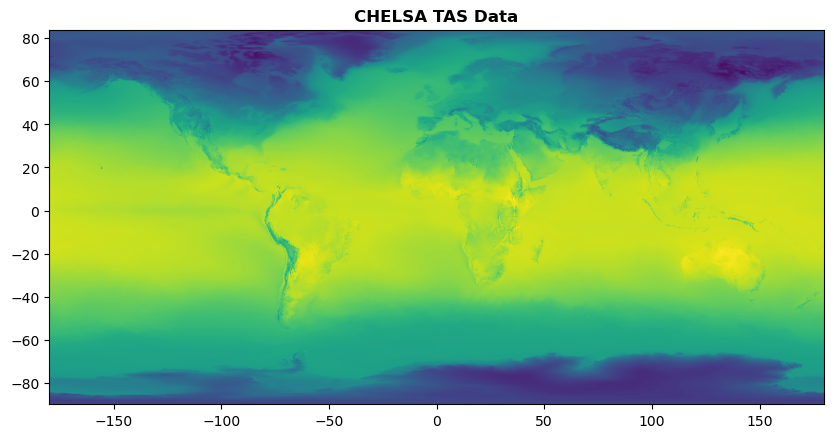

<Figure size 640x480 with 0 Axes>

In [2]:
import xarray as xr
from pathlib import Path
import numpy as np
# 读取tif文件
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

raster_path = r'D:\xarray\pre-process\Climate_tas\CHELSA_tas_01_2000_V.2.1.tif'



# 打开tif文件
with rasterio.open(raster_path) as src:
    # 显示波段数量
    print(f"Number of bands: {src.count}")
    
    # 读取数据
    raster_data = src.read(1)  # 读取第一个波段
    
    # 显示基本信息
    print(f"Raster shape: {raster_data.shape}")
    print(f"Raster data type: {raster_data.dtype}")
    print(f"Bounds: {src.bounds}")
    print(f"CRS: {src.crs}")
    
    # 可视化
    plt.figure(figsize=(10, 6))
    show(src, title="CHELSA TAS Data")
    plt.tight_layout()
    plt.show()


In [11]:
from pathlib import Path

def collect_gdmp_files(base_dir):
    """
    收集所有GDMP文件夹中的NC文件路径
    
    Parameters:
    -----------
    base_dir : str
        基础目录路径
    
    Returns:
    --------
    list
        包含所有NC文件绝对路径的列表
    """
    base_path = Path(base_dir)
    
    # 获取所有以c_gls_GDMP开头的文件夹
    gdmp_folders = [f for f in base_path.iterdir() if f.is_dir() and f.name.startswith('c_gls_GDMP')]
    
    # 收集所有NC文件路径
    nc_files = []
    for folder in gdmp_folders:
        nc_files.extend(folder.glob('*.nc'))
    
    # 转换为绝对路径
    nc_files = [str(f.absolute()) for f in nc_files]
    
    return nc_files


base_dir = r"D:\xarray\pre-process\Gross_productivity"

nc_files = collect_gdmp_files(base_dir)



    

GDMP数据查询、检查

In [13]:
ts=xr.open_dataset(nc_files[0])
var_name = list(ts.data_vars)[1]
da = ts[var_name]
da

<xarray.DataArray 'GDMP' (time: 1, lat: 15680, lon: 40320)> Size: 3GB
[632217600 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 323kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat      (lat) float64 125kB 80.0 79.99 79.98 79.97 ... -59.97 -59.98 -59.99
  * time     (time) datetime64[ns] 8B 2020-06-30
Attributes:
    grid_mapping:   crs
    long_name:      Gross dry matter productivity 1KM
    units:          kg / hectare / day
    valid_range:    [    0 32767]
    flag_meanings:  Missing Sea
    flag_values:    [-1 -2]

c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 19981 (\N{CJK UNIFIED IDEOGRAPH-4E0D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21516 (\N{CJK UNIFIED IDEOGRAPH-540C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32428 (\N{CJK UNIFIED IDEOGRAPH-7EAC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30340 (\N{CJK

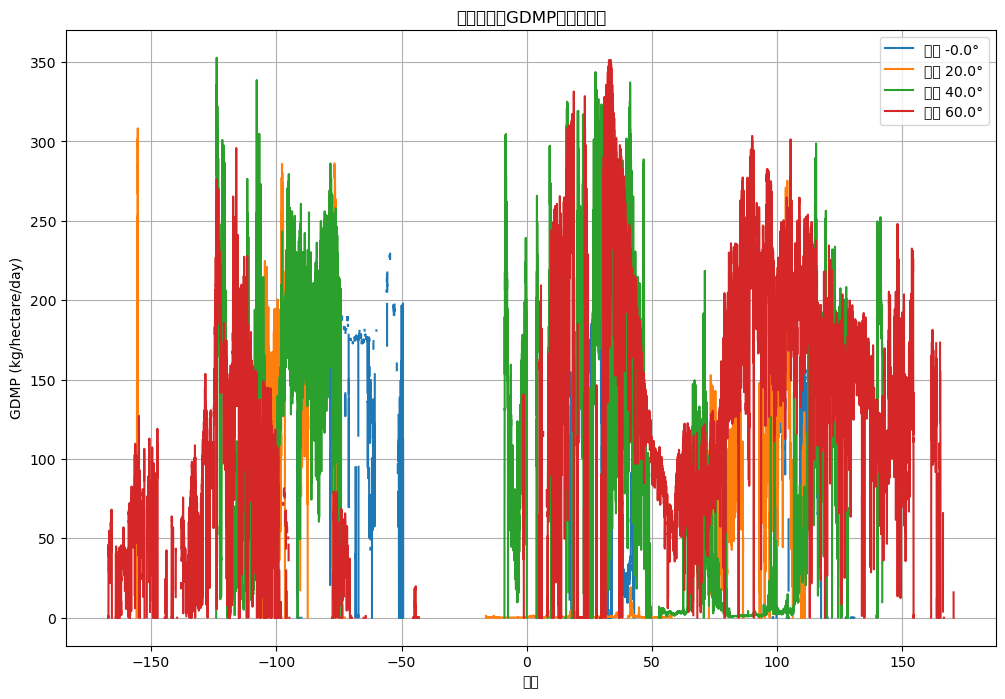

In [7]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

# 加载数据
look = r'D:\xarray\aligned\gdmp\c_gls_GDMP-RT0_202006300000_GLOBE_PROBAV_V2.0.1.nc'
look = xr.open_dataset(look)

# 获取GDMP数据
gdmp_data = look['GDMP']

# 选择几个不同纬度进行沿经度的折线图绘制
latitudes = [0, 20, 40, 60]  # 选择赤道、北纬20度、40度和60度
plt.figure(figsize=(12, 8))

for lat in latitudes:
    # 找到最接近所选纬度的实际纬度值
    lat_idx = np.abs(gdmp_data.lat.values - lat).argmin()
    actual_lat = gdmp_data.lat.values[lat_idx]
    
    # 提取该纬度的数据（沿经度的横截面）
    lon_profile = gdmp_data.isel(lat=lat_idx).squeeze()
    
    # 绘制折线图
    plt.plot(gdmp_data.lon, lon_profile, label=f'纬度 {actual_lat:.1f}°')

plt.title('不同纬度的GDMP沿经度分布')
plt.xlabel('经度')
plt.ylabel('GDMP (kg/hectare/day)')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
look

<xarray.Dataset> Size: 4GB
Dimensions:      (lon: 43200, lat: 21600)
Coordinates:
  * lon          (lon) float64 346kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat          (lat) float64 173kB 90.0 89.99 89.98 ... -89.98 -89.99 -90.0
    spatial_ref  int32 4B ...
Data variables:
    GDMP         (lat, lon) float32 4GB nan nan nan nan nan ... nan nan nan nan

In [11]:
from pathlib import Path
import rasterio
from tqdm import tqdm

def get_tiff_info(tiff_path):
    """获取TIFF文件的关键信息"""
    try:
        with rasterio.open(tiff_path) as src:
            # 获取波段描述
            band_names = []
            for i in range(src.count):
                desc = src.descriptions[i] if src.descriptions else f'Band {i+1}'
                band_names.append(desc)
            
            return {
                'filename': Path(tiff_path).name,
                'bands': src.count,
                'band_names': band_names,
                'crs': src.crs.to_string() if src.crs else 'None',
                'res': (src.res[0], src.res[1]),
                'size': (src.width, src.height)
            }
    except Exception as e:
        return {'filename': Path(tiff_path).name, 'error': str(e)}

def scan_tiff_files(base_dir):
    """扫描目录下的TIFF文件"""
    base_path = Path(base_dir)
    # 只获取当前目录下的tif文件，不遍历子目录
    tiff_files = list(base_path.glob("*.tif"))
    
    if not tiff_files:
        print(f"在目录 {base_dir} 中未找到TIFF文件")
        return
    
    print(f"\n找到 {len(tiff_files)} 个TIFF文件:\n")
    
    # 处理每个文件
    for tiff_path in tqdm(tiff_files, desc="扫描TIFF文件"):
        info = get_tiff_info(tiff_path)
        
        if 'error' in info:
            print(f"{info['filename']}: 错误 - {info['error']}")
            continue
            
        print(f"{info['filename']}:")
        print(f"  波段数: {info['bands']}")
        if info['bands'] > 1:
            print("  波段名称:")
            for i, name in enumerate(info['band_names'], 1):
                print(f"    {i}. {name}")
        print(f"  投影: {info['crs']}")
        print(f"  分辨率: {info['res'][0]:.6f} x {info['res'][1]:.6f} 度")
        print(f"  大小: {info['size'][0]} x {info['size'][1]} 像素")
        print()

def main():
    base_dir = r"D:\xarray\pre-process"
    try:
        scan_tiff_files(base_dir)
    except Exception as e:
        print(f"扫描过程中出错: {str(e)}")

if __name__ == "__main__":
    main()


找到 12 个TIFF文件:



扫描TIFF文件:  25%|██▌       | 3/12 [00:00<00:01,  8.46it/s]

Global_elevation_1KMmn_GMTEDmn.tif:
  波段数: 1
  投影: GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
  分辨率: 0.008333 x 0.008333 度
  大小: 43200 x 16800 像素

Global_rast_adm2_gdp_perCapita_1990_2022.tif:
  波段数: 33
  波段名称:
    1. gdp_pc_1990
    2. gdp_pc_1991
    3. gdp_pc_1992
    4. gdp_pc_1993
    5. gdp_pc_1994
    6. gdp_pc_1995
    7. gdp_pc_1996
    8. gdp_pc_1997
    9. gdp_pc_1998
    10. gdp_pc_1999
    11. gdp_pc_2000
    12. gdp_pc_2001
    13. gdp_pc_2002
    14. gdp_pc_2003
    15. gdp_pc_2004
    16. gdp_pc_2005
    17. gdp_pc_2006
    18. gdp_pc_2007
    19. gdp_pc_2008
    20. gdp_pc_2009
    21. gdp_pc_2010
    22. gdp_pc_2011
    23. gdp_pc_2012
    24. gdp_pc_2013
    25. gdp_pc_2014
    26. gdp_pc_2015
    27. gdp_pc_2016
    28. gdp_pc_2017
    29. gdp_pc_2018
    30. gdp_pc_2019
    31. gdp_pc_2020


扫描TIFF文件:  42%|████▏     | 5/12 [00:00<00:00,  9.11it/s]

Global_slope_1KMmn_GMTEDmd.tif:
  波段数: 1
  投影: GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
  分辨率: 0.008333 x 0.008333 度
  大小: 43200 x 16800 像素

gpw_v4_population_density_rev11_2000_30_sec.tif:
  波段数: 1
  投影: GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
  分辨率: 0.008333 x 0.008333 度
  大小: 43200 x 21600 像素

gpw_v4_population_density_rev11_2005_30_sec.tif:
  波段数: 1
  投影: GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
  分辨率: 0.008333 x 0.008333 度
  大小: 43200 x 21600 像素



扫描TIFF文件:  75%|███████▌  | 9/12 [00:00<00:00, 11.03it/s]

gpw_v4_population_density_rev11_2015_30_sec.tif:
  波段数: 1
  投影: GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
  分辨率: 0.008333 x 0.008333 度
  大小: 43200 x 21600 像素

gpw_v4_population_density_rev11_2020_30_sec.tif:
  波段数: 1
  投影: GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
  分辨率: 0.008333 x 0.008333 度
  大小: 43200 x 21600 像素

GURS_2005.tif:
  波段数: 1
  投影: PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PA

扫描TIFF文件: 100%|██████████| 12/12 [00:01<00:00, 10.62it/s]

GURS_2015.tif:
  波段数: 1
  投影: PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
  分辨率: 100.000000 x 100.000000 度
  大小: 352420 x 148534 像素

GURS_2020.tif:
  波段数: 1
  投影: PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
  分辨率: 100.000000 x 100.000000 度
  大小: 352421 x 148534 像素



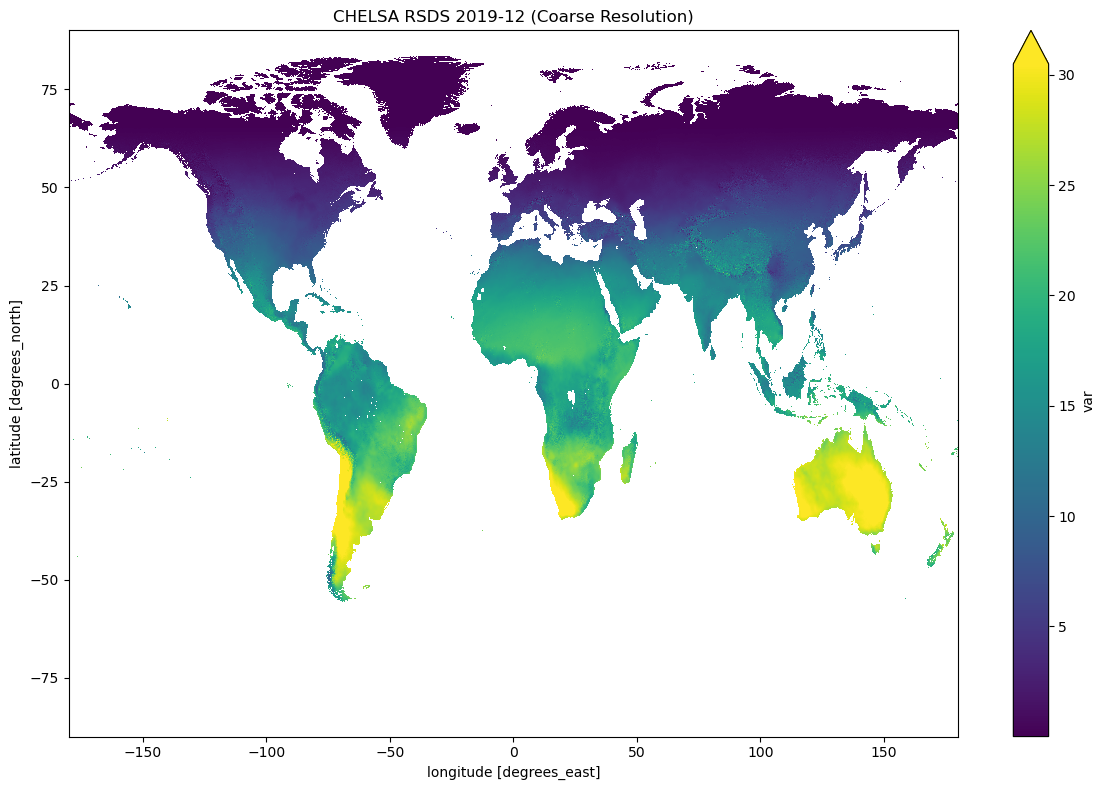

<xarray.Dataset> Size: 4GB
Dimensions:      (lon: 43200, lat: 21600)
Coordinates:
    spatial_ref  int32 4B ...
  * lon          (lon) float64 346kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat          (lat) float64 173kB 90.0 89.99 89.98 ... -89.98 -89.99 -90.0
    time         datetime64[ns] 8B ...
Data variables:
    var          (lat, lon) float32 4GB ...

In [14]:
import xarray as xr
import matplotlib.pyplot as plt

# Load the dataset
look2_path = r'D:\xarray\aligned\rsds\CHELSA_rsds_2019_12_V.2.1.nc'
loo2 = xr.open_dataset(look2_path)

# Plot the dataset using coarse method
plt.figure(figsize=(12, 8))
# Using coarse method by selecting every nth point to reduce plotting density
coarse_factor = 10  # Adjust this value based on your dataset size

# Fix: Access the data variable directly instead of using .var function
# First, identify the main data variable in the dataset
data_var_name = list(loo2.data_vars)[0]  # Get the first data variable name
loo2[data_var_name].isel(lat=slice(None, None, coarse_factor), 
                         lon=slice(None, None, coarse_factor)).plot(
    cmap='viridis',
    robust=True
)
plt.title('CHELSA RSDS 2019-12 (Coarse Resolution)')
plt.tight_layout()
plt.show()

# Display the dataset info
loo2


In [24]:
from align import align_df_with_ds
import pandas as pd
import os

csv_path = "global_solar_2020.csv"  # Using relative path

if os.path.exists(csv_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_path)
    
    # Display basic information about the DataFrame
    print(f"CSV file loaded successfully. Shape: {df.shape}")
    print("\nFirst 5 rows of the DataFrame:")
    print(df.head())
    
    # Display column information
    print("\nColumn information:")
    print(df.info())
    
    # Check for missing values
    print("\nMissing values per column:")
    print(df.isnull().sum())




CSV file loaded successfully. Shape: (35272, 10)

First 5 rows of the DataFrame:
   sol_id GID_0  panels    p_area  l_area  water  urban  power        lat  \
0       1   CAN     1.0  0.000141     0.0    0.0    0.0    0.0  48.732666   
1       2   USA     1.0  0.000141     0.0    0.0    0.0    0.0  47.020474   
2       3   USA     1.0  0.000141     0.0    0.0    1.0    0.0  44.582127   
3       4   USA     1.0  0.000141     0.0    0.0    1.0    0.0  37.405178   
4       5   USA     1.0  0.000141     0.0    0.0    1.0    0.0  37.847172   

          lon  
0 -123.496376  
1 -120.223221  
2 -123.286964  
3 -122.084770  
4 -122.271530  

Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35272 entries, 0 to 35271
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sol_id  35272 non-null  int64  
 1   GID_0   35272 non-null  object 
 2   panels  35272 non-null  float64
 3   p_area  35272 non-null  float64
 4   l_a

In [25]:
import pandas as pd
import xarray as xr
from align import align_df_with_ds, align_df_with_ds_trim

# 读取参考栅格
master_path = r'D:\xarray\aligned\master_land_0509.nc'
ds = xr.open_dataset(master_path)

# 重命名数据集的坐标
ds = ds.rename({'lon': 'longitude', 'lat': 'latitude'})

# 读取你的CSV文件
df = pd.read_csv(csv_path)  # 替换为你的CSV文件路径

# 重命名列以匹配align函数的要求
df = df.rename(columns={
    'lon': 'longitude',
    'lat': 'latitude'
})

# 使用align_df_with_ds进行对齐
# 方法1：使用trim=False（保留所有点）
aligned_df = align_df_with_ds(df, ds, trim=False, inplace=True)

# 或者方法2：使用trim=True（删除超出范围的点）
# aligned_df = align_df_with_ds_trim(df, ds, delta_lon_lat=0.1, mode="Align", inplace=True)

# 打印结果信息
print(f"原始数据点数量: {len(df)}")
print(f"对齐后数据点数量: {len(aligned_df)}")
print(f"参考栅格分辨率: {ds.longitude.values[1] - ds.longitude.values[0]:.6f} 度")

# 查看前几行结果
print("\n对齐后的前5行数据:")
print(aligned_df[['longitude', 'latitude']].head())

# 保存结果
aligned_df.to_csv('aligned_coordinates.csv', index=False)

# 关闭数据集
ds.close()

原始数据点数量: 35272
对齐后数据点数量: 35272
参考栅格分辨率: 0.008333 度

对齐后的前5行数据:
    longitude   latitude
0 -123.495833  48.729167
1 -120.220833  47.020833
2 -123.287500  44.579167
3 -122.087500  37.404167
4 -122.270833  37.845833


# 撂荒数据修复

        if path.endswith('chunk_20_46.nc') or path.endswith('chunk_20_51.nc') or path.endswith('chunk_5_56.nc') or path.endswith('chunk_6_79.nc'):


In [38]:
import os
import gc
import re
import numpy as np
import xarray as xr
from dask.distributed import Client, as_completed
from tqdm import tqdm

# === 1. 启动 Dask 分布式客户端 ===
client = Client()  
print(f"Dask Dashboard: {client.dashboard_link}")

# === 2. 路径 & 参数设置 ===
input_path = r'D:\xarray\reclass_lccs_1km.nc'
mask_path  = r'D:\xarray\final_mask_1km_new.nc'
out_dir    = r'D:\xarray\abandonment_rectify'
os.makedirs(out_dir, exist_ok=True)

chunk_size_lat = 500
chunk_size_lon = 500

# === 3. 打开并 persist 数据 ===
ds       = xr.open_dataset(input_path, chunks={'time':1})
ds       = client.persist(ds)  # 保持在集群内存
mask_ds  = xr.open_dataset(mask_path)
years    = ds.time.dt.year.values
lat_size = ds.sizes['lat']
lon_size = ds.sizes['lon']

# === 4. 构造有效像元列表 & 分块映射 ===
valid  = (mask_ds['final_mask'] == 1).values
ys, xs = np.where(valid)
pixels = list(zip(ys, xs))

chunk_map = {}
for y, x in pixels:
    ci = y // chunk_size_lat
    cj = x // chunk_size_lon
    key = (ci, cj)
    rel = (y % chunk_size_lat, x % chunk_size_lon, y, x)
    chunk_map.setdefault(key, []).append(rel)

# === 5. 分类 & 撂荒检测函数 ===
def classify_category(v):
    if   v==1:         return '1'
    elif v==7:         return '7'
    elif v in (8,9):   return 'X'
    else:              return '0'

def classify_sequence_current_only(seq):
    s = ''.join(classify_category(v) for v in seq)
    if not s.startswith("11"):
        return np.nan,0,0,0
    matches = list(re.finditer(r"1{2,}(0{5,})", s))
    if not matches:
        return np.nan,0,0,0
    m     = matches[-1]
    start = m.start(1)
    dur   = len(m.group(1))
    year0 = years[start+1]
    after = s[m.end():]
    rec   = int('11' in after)      # 至少两年耕地复垦
    built = int('7' in after)
    curr  = int(not(rec or built))
    return year0, dur, rec, curr

# === 6. 主处理函数（Worker 上执行） ===
def process_chunk(key, pixel_list):
    ci, cj = key
    ys, xs = ci*chunk_size_lat, cj*chunk_size_lon
    ye, xe = min(ys+chunk_size_lat, lat_size), min(xs+chunk_size_lon, lon_size)
    sub = ds.isel(lat=slice(ys,ye), lon=slice(xs,xe)).load()
    arr = sub['lccs_class'].values    # (time, h, w)
    t,h,w = arr.shape
    # 预分配
    year0 = np.full((h,w), np.nan, dtype=np.float32)
    dur   = np.full((h,w), np.nan, dtype=np.float32)
    rec   = np.zeros((h,w), dtype=np.uint8)
    curr  = np.zeros((h,w), dtype=np.uint8)
    for ly, lx, _, _ in pixel_list:
        y0,d,r,c = classify_sequence_current_only(arr[:,ly,lx])
        if not np.isnan(y0):
            year0[ly,lx] = y0
            dur[ly,lx]   = d
            rec[ly,lx]   = r
            curr[ly,lx]  = c
    # 构造 Dataset 并写出
    out = xr.Dataset(
        data_vars={
            'abandonment_year':      (('lat','lon'), year0),
            'abandonment_duration':  (('lat','lon'), dur),
            'recultivation':         (('lat','lon'), rec),
            'current_abandonment':   (('lat','lon'), curr)
        },
        coords={'lat':sub.lat, 'lon':sub.lon}
    )
    encoding = {
        'abandonment_year':     {'zlib':True,'complevel':9,'dtype':'float32','_FillValue':np.nan},
        'abandonment_duration': {'zlib':True,'complevel':9,'dtype':'float32','_FillValue':np.nan},
        'recultivation':        {'zlib':True,'complevel':9,'dtype':'uint8','_FillValue':0},
        'current_abandonment':  {'zlib':True,'complevel':9,'dtype':'uint8','_FillValue':0},
    }
    path = os.path.join(out_dir, f'chunk_{ci}_{cj}.nc')
    out.to_netcdf(path, encoding=encoding)
    # 清理
    del sub, out, arr
    gc.collect()
    return path

# === 7. 处理特定的chunk ===
target_chunks = [
    (20, 46),  # chunk_20_46.nc
    (20, 51),  # chunk_20_51.nc
    (5, 56),   # chunk_5_56.nc
    (6, 79)    # chunk_6_79.nc
]

futures = []
for ci, cj in target_chunks:
    if (ci, cj) in chunk_map:
        print(f"处理 chunk_{ci}_{cj}")
        futures.append(client.submit(process_chunk, (ci, cj), chunk_map[(ci, cj)]))

# 等待所有任务完成
for fut in as_completed(futures):
    path = fut.result()
    print(f"完成: {path}")

print("✅ 所有指定的chunk已处理并保存。")

# 关闭客户端
client.close()

c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\distributed\dashboard\core.py:20: UserWarning: 
Dask needs bokeh >= 2.4.2, < 3 for the dashboard.
You have bokeh==3.6.3.
Continuing without the dashboard.
  warnings.warn(


Dask Dashboard: http://127.0.0.1:8787/status
处理 chunk_20_46
处理 chunk_20_51
处理 chunk_5_56
处理 chunk_6_79
完成: D:\xarray\abandonment_rectify\chunk_20_46.nc
完成: D:\xarray\abandonment_rectify\chunk_20_51.nc
完成: D:\xarray\abandonment_rectify\chunk_5_56.nc
完成: D:\xarray\abandonment_rectify\chunk_6_79.nc
✅ 所有指定的chunk已处理并保存。


2025-05-10 18:23:07,692 - distributed.nanny - WARNING - Worker process still alive after 3.1999714660644534 seconds, killing
2025-05-10 18:23:07,723 - distributed.nanny - WARNING - Worker process still alive after 3.1999989318847657 seconds, killing
2025-05-10 18:23:07,724 - distributed.nanny - WARNING - Worker process still alive after 3.1999990844726565 seconds, killing
2025-05-10 18:23:07,724 - distributed.nanny - WARNING - Worker process still alive after 3.1999990844726565 seconds, killing
2025-05-10 18:23:08,485 - distributed.nanny - ERROR - Error in Nanny killing Worker subprocess
Traceback (most recent call last):
  File "c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\distributed\utils.py", line 1844, in wait_for
    return await fut
           ^^^^^^^^^
asyncio.exceptions.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\distri

正在读取: chunk_20_46.nc
成功读取: chunk_20_46.nc
数据集形状: FrozenMappingWarningOnValuesAccess({'lat': 500, 'lon': 500})
变量列表: ['abandonment_year', 'abandonment_duration', 'recultivation', 'current_abandonment', 'lat', 'lon']
abandonment_year 有效值数量: 752
--------------------------------------------------
正在读取: chunk_20_51.nc
成功读取: chunk_20_51.nc
数据集形状: FrozenMappingWarningOnValuesAccess({'lat': 500, 'lon': 500})
变量列表: ['abandonment_year', 'abandonment_duration', 'recultivation', 'current_abandonment', 'lat', 'lon']
abandonment_year 有效值数量: 1779
--------------------------------------------------
正在读取: chunk_5_56.nc
成功读取: chunk_5_56.nc
数据集形状: FrozenMappingWarningOnValuesAccess({'lat': 500, 'lon': 500})
变量列表: ['abandonment_year', 'abandonment_duration', 'recultivation', 'current_abandonment', 'lat', 'lon']
abandonment_year 有效值数量: 2
--------------------------------------------------
正在读取: chunk_6_79.nc
成功读取: chunk_6_79.nc
数据集形状: FrozenMappingWarningOnValuesAccess({'lat': 500, 'lon': 500})
变量列表: ['aband

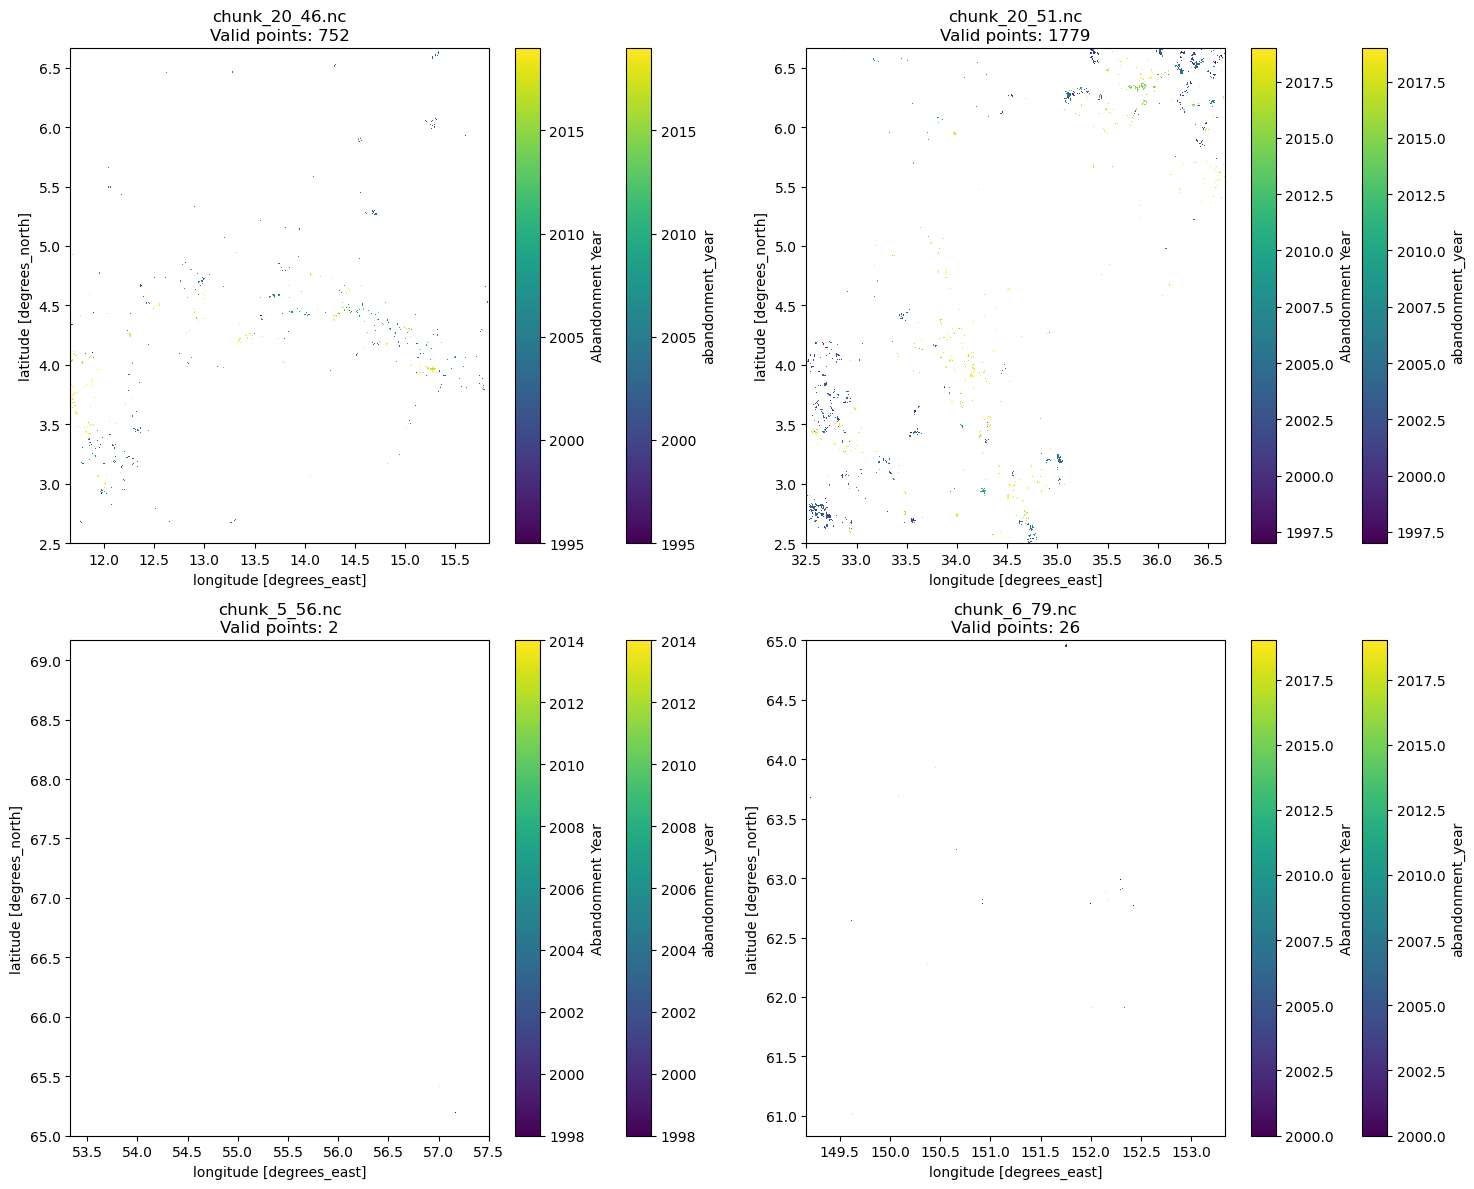


总结:
chunk_20_46.nc: abandonment_year 有效值数量 = 752
chunk_20_51.nc: abandonment_year 有效值数量 = 1779
chunk_5_56.nc: abandonment_year 有效值数量 = 2
chunk_6_79.nc: abandonment_year 有效值数量 = 26
所有文件 abandonment_year 有效值总数: 2559


<xarray.Dataset> Size: 4MB
Dimensions:               (lat: 500, lon: 500)
Coordinates:
  * lat                   (lat) float64 4kB 6.663 6.654 6.646 ... 2.513 2.504
  * lon                   (lon) float64 4kB 11.67 11.68 11.69 ... 15.82 15.83
Data variables:
    abandonment_year      (lat, lon) float32 1MB nan nan nan nan ... nan nan nan
    abandonment_duration  (lat, lon) float32 1MB ...
    recultivation         (lat, lon) float32 1MB ...
    current_abandonment   (lat, lon) float32 1MB ...

In [41]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 基础目录
base_dir = r'D:\xarray\abandonment_rectify'

# 需要读取的文件列表
target_files = [
    'chunk_20_46.nc',
    'chunk_20_51.nc',
    'chunk_5_56.nc',
    'chunk_6_79.nc'
]

# 存储所有数据集的列表
datasets = []
valid_counts = []

# 设置图形大小
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
axs = axs.flatten()

# 读取每个文件并绘图
for i, file in enumerate(target_files):
    file_path = f"{base_dir}/{file}"
    try:
        print(f"正在读取: {file}")
        ds = xr.open_dataset(file_path)
        datasets.append(ds)
        
        # 计算有效值数量
        valid_count = np.sum(~np.isnan(ds.abandonment_year.values))
        valid_counts.append(valid_count)
        
        print(f"成功读取: {file}")
        print(f"数据集形状: {ds.dims}")
        print(f"变量列表: {list(ds.variables)}")
        print(f"abandonment_year 有效值数量: {valid_count}")
        
        # 绘制数据
        im = ds.abandonment_year.plot(ax=axs[i], cmap='viridis')
        axs[i].set_title(f"{file}\nValid points: {valid_count}")
        plt.colorbar(im, ax=axs[i], label='Abandonment Year')
        
        print("-" * 50)
    except Exception as e:
        print(f"读取 {file} 时出错: {str(e)}")
        axs[i].text(0.5, 0.5, f"Error loading {file}", ha='center', va='center')

plt.tight_layout()
plt.show()

# 总结有效值数量
print("\n总结:")
for i, file in enumerate(target_files):
    print(f"{file}: abandonment_year 有效值数量 = {valid_counts[i]}")
print(f"所有文件 abandonment_year 有效值总数: {sum(valid_counts)}")

# 查看第一个数据集的基本信息
datasets[0]

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

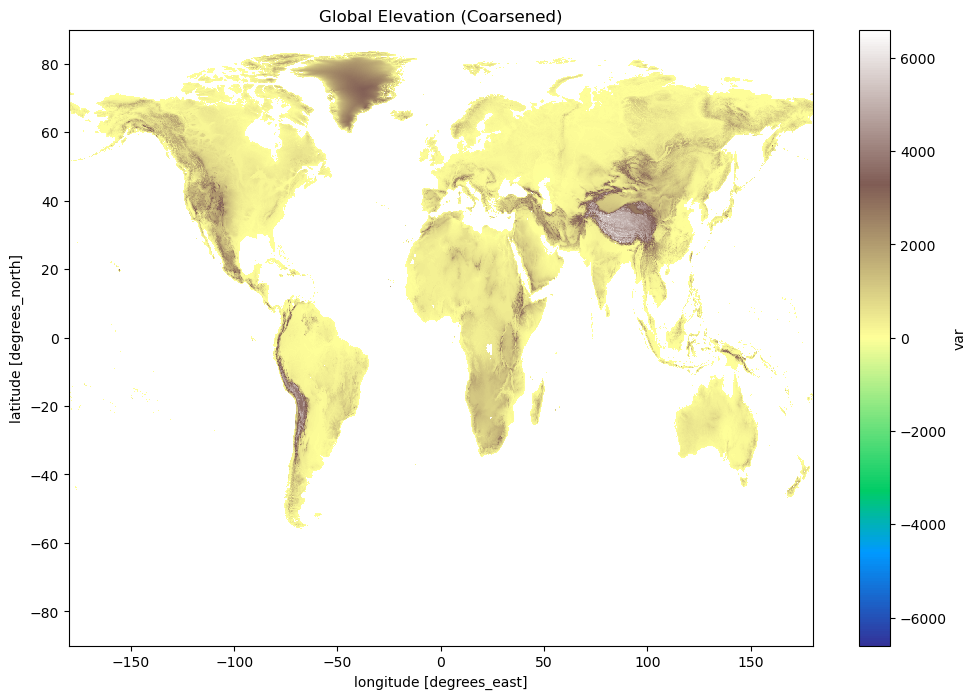

In [46]:
import xarray as xr
import matplotlib.pyplot as plt

path=r'D:\xarray\aligned\social\Global_elevation_1KMmn_GMTEDmn_var.nc'

look3=xr.open_dataset(path)
look3

# Coarsen the dataset to reduce resolution for better visualization
# This reduces the data by taking the mean of each 10x10 grid cell
coarsened_data = look3['var'].coarsen(lat=10, lon=10, boundary='trim').mean()

# Plot the coarsened dataset
plt.figure(figsize=(12, 8))
coarsened_data.plot(cmap='terrain')
plt.title('Global Elevation (Coarsened)')
plt.colorbar(label='Elevation (m)')
plt.tight_layout()
plt.show()

# Plot original vs coarsened data
fig, axs = plt.subplots(1, 2, figsize=(18, 8))
look3['var'].plot(ax=axs[0], cmap='terrain')
axs[0].set_title('Original Resolution')
coarsened_data.plot(ax=axs[1], cmap='terrain')
axs[1].set_title('Coarsened (10x10)')
plt.tight_layout()
plt.show()

# Display dataset information
print(look3)


# 路网、电网的累计距离

In [5]:
import arcpy, os
from arcpy.sa import DistanceAccumulation

# 输入与工作区路径
settlement_in  = r"D:\xarray\pre-process\GURS_2015.tif"
gdp_in         = r'D:\Photovoltaic_data\Global_rast_gdpTot_1990_2020_30arcsec.tif'
out_folder     = r"D:\xarray\tif2nc_out"
scratch_gdb    = os.path.join(out_folder, "gis_temp.gdb")
arcpy.env.overwriteOutput           = True

# 确保 scratch gdb 存在
if not arcpy.Exists(scratch_gdb):
    arcpy.CreateFileGDB_management(out_folder, "gis_temp.gdb")

# 设定目标投影为 Mollweide
mollweide = arcpy.SpatialReference(54009)

# 投影并重采样 settlement（离散分类用 NEAREST）
sett_set = os.path.join(scratch_gdb, "GURS_2015_disnew")
arcpy.management.ProjectRaster(
    settlement_in, sett_set,
    out_coor_system=mollweide,
    resampling_type="NEAREST",
    cell_size="1000"  
)

# # 投影并重采样 gdp（连续栅格用 BILINEAR）
# gdp_set = os.path.join(scratch_gdb, "gdp_dis")
# arcpy.management.ProjectRaster(gdp_in, gdp_set,
#     out_coor_system=mollweide,
#     resampling_type="BILINEAR",
#     cell_size="1000"
# )


<Result 'D:\\xarray\\tif2nc_out\\gis_temp.gdb\\GURS_2015_disnew'>

In [4]:
import arcpy, os
from arcpy.sa import DistanceAccumulation

# ── 准备工作区 ─────────────────────────
out_folder   = r"D:\xarray\tif2nc_out"
scratch_gdb  = os.path.join(out_folder, "gis_temp.gdb")
if not arcpy.Exists(scratch_gdb):
    arcpy.CreateFileGDB_management(out_folder, os.path.basename(scratch_gdb))

arcpy.env.overwriteOutput           = True
arcpy.env.scratchWorkspace          = scratch_gdb
arcpy.env.parallelProcessingFactor  = "1"           # 单实例
arcpy.env.cellSize                  = 1000           # 与投影时的重采样一致

# ── 内存管理设置 ─────────────────────────
# 限制ArcGIS使用的内存到6GB以内
arcpy.env.tileSize = "32 32"        # 减小处理瓦片大小以降低内存使用
arcpy.env.pyramid = "NONE"          # 不创建金字塔以节省内存

# ── **围住人口栅格范围** ───────────────────
gdp_set = os.path.join(scratch_gdb, "gdp_dis")  # 已投影&重采样后的人口栅格
gdp_raster = arcpy.Raster(gdp_set)

# 只在它的矩形范围内计算
arcpy.env.extent     = gdp_raster  
# 以它为对齐基准，确保网格一模一样
arcpy.env.snapRaster = gdp_raster  
# 把它设为 Mask，Tool 不会在其 NoData 区域计算
arcpy.env.mask       = gdp_raster  

# ── 分块处理距离累积 ─────────────────────────
# settlements 是同样投影下的离散分类栅格（1/2）
sett_set = os.path.join(scratch_gdb, "GURS_2015_disnew")
sett_raster = arcpy.Raster(sett_set)

# 检出空间分析扩展模块
arcpy.CheckOutExtension("Spatial")

# 创建临时输出路径
temp_output = os.path.join(scratch_gdb, "temp_distance")

# 使用较低的内存设置运行距离累积
out = DistanceAccumulation(
    in_source_data=sett_raster,
    distance_method="PLANAR",      # 已经是米制投影，直接平面距离,       # 设置最大距离限制以减少计算量
)

# ── 保存并清理 ───────────────────────────────
output_path = os.path.join(out_folder, "Dist_GUR_masked_2015.tif")
out.save(output_path)

# 释放内存
del out, sett_raster, gdp_raster

# 手动触发垃圾回收
import gc
gc.collect()




0

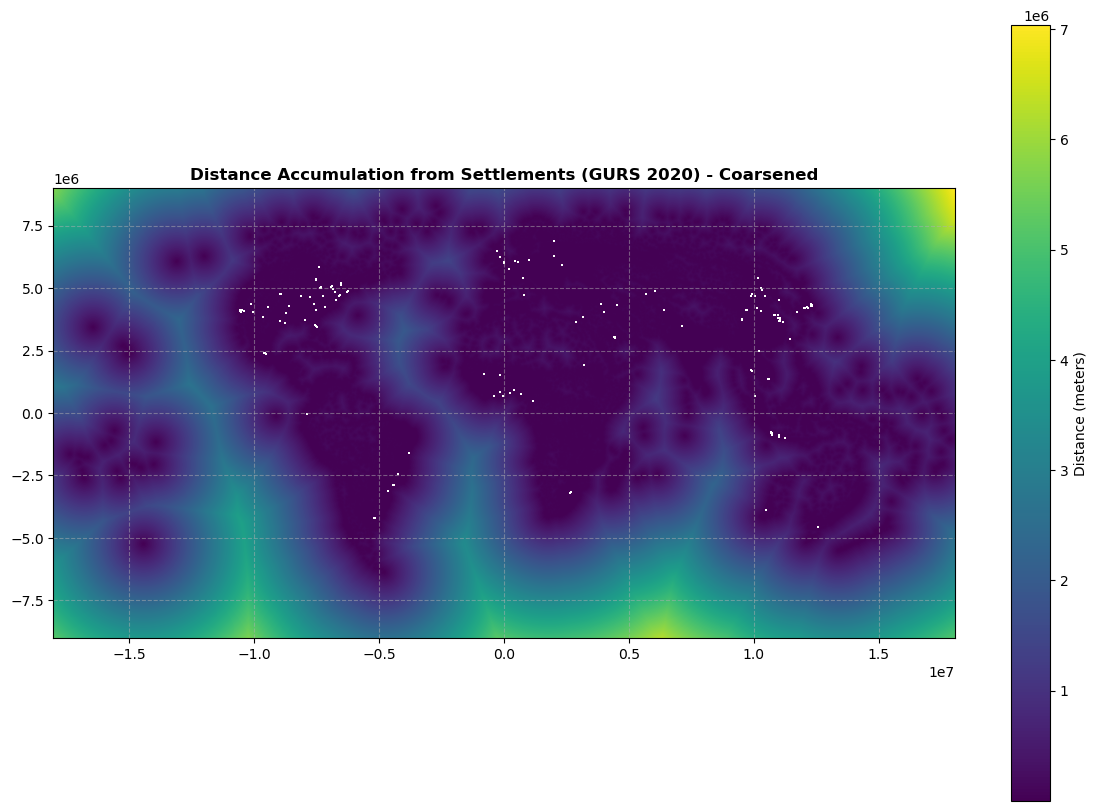

原始数据大小: 18001 x 36081 像素
降采样后大小: 1800 x 3608 像素
数据量减少: 100.0倍


In [6]:
# 导入必要的库
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from rasterio.plot import show
from matplotlib import cm
from rasterio.enums import Resampling

# 打开栅格文件
with rasterio.open(r"D:\xarray\tif2nc_out\Dist_GUR_masked_.tif") as src:
    # 读取栅格数据，使用降采样以减少数据量
    # 计算降采样因子
    scale_factor = 10  # 降采样10倍，可以根据需要调整
    
    # 计算新的尺寸
    height = int(src.height // scale_factor)
    width = int(src.width // scale_factor)
    
    # 使用降采样读取数据
    distance_data = src.read(
        1,
        out_shape=(height, width),
        resampling=Resampling.average
    )
    
    # 调整变换以匹配新的分辨率
    transform = src.transform * src.transform.scale(
        (src.width / width),
        (src.height / height)
    )
    
    # 创建一个更大的图形
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # 设置一个合适的颜色映射
    cmap = plt.cm.viridis
    
    # 处理无效值（如果有）
    mask = np.ma.masked_where(distance_data <= 0, distance_data)
    
    # 绘制降采样后的栅格数据
    im = show(mask, ax=ax, cmap=cmap, transform=transform, 
              title='Distance Accumulation from Settlements (GURS 2020) - Coarsened')
    
    # 创建一个ScalarMappable对象用于颜色条
    norm = plt.Normalize(vmin=mask.min(), vmax=mask.max())
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    
    # 添加颜色条
    cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
    cbar.set_label('Distance (meters)')
    
    # 添加网格线
    ax.grid(True, linestyle='--', alpha=0.5)
    
    # 显示图形
    plt.tight_layout()
    plt.show()
    
    # 打印原始和降采样后的数据大小比较
    print(f"原始数据大小: {src.height} x {src.width} 像素")
    print(f"降采样后大小: {height} x {width} 像素")
    print(f"数据量减少: {(src.height * src.width) / (height * width):.1f}倍")


# 路网矫正

In [7]:
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import numpy as np
import gc
from tqdm import tqdm
import os
import logging

# 配置日志
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('distance_align.log'),
        logging.StreamHandler()
    ]
)

# ───────── 配置 ─────────
MASTER = Path(r"D:\xarray\aligned2\master_final.nc")
SRC_DIR = Path(r"D:\xarray\tif2nc_out")
OUT_DIR = Path(r"D:\xarray\aligned2\distance")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# 要处理的文件列表
target_files = [
    "Dist_GUR_masked_2015.tif",
    "Dist_GUR_masked.tif"
]

def process_distance_file(fp, tmpl_data):
    """处理单个距离文件"""
    lat, lon, mask, chunk_lat, chunk_lon = tmpl_data
    out_nc = OUT_DIR / f"{Path(fp).stem}.nc"
    
    if out_nc.exists():
        logging.info(f"Skipping existing file: {out_nc}")
        return
    
    try:
        logging.info(f"Processing {fp}")
        
        # 读入时就分块
        da = (
            rxr.open_rasterio(fp, masked=True,
                            chunks={"x": chunk_lon, "y": chunk_lat})
            .squeeze("band", drop=True)
            .rio.set_spatial_dims("x", "y", inplace=False)
            .rename({"x": "lon", "y": "lat"})
        )
        
        # 将纬度分成更小的块进行处理
        lat_chunks = np.array_split(lat.values, 20)  # 增加分块数量到20
        da_parts = []
        
        for i, lat_chunk in enumerate(tqdm(lat_chunks, desc="Processing chunks")):
            # 对每个纬度块进行插值
            da_chunk = da.interp(lon=lon, lat=lat_chunk, method="linear")
            # 应用掩膜
            mask_chunk = mask.sel(lat=lat_chunk)
            da_chunk_masked = da_chunk.where(mask_chunk)
            da_parts.append(da_chunk_masked)
            
            # 立即清理内存
            da_chunk = None
            mask_chunk = None
            gc.collect()
        
        # 沿纬度方向合并所有块
        da_masked = xr.concat(da_parts, dim="lat")
        
        # 清理临时变量
        da_parts = None
        gc.collect()
        
        # 构造 Dataset 并分块
        var = "distance"  # 使用统一的变量名
        ds = da_masked.to_dataset(name=var) \
                    .chunk({"lat": chunk_lat, "lon": chunk_lon})
        
        # 写出 NetCDF（使用更保守的压缩设置）
        encoding = {
            var: {
                "zlib": True,
                "complevel": 1,  # 使用最低压缩级别
                "chunksizes": (chunk_lat, chunk_lon)
            }
        }
        
        # 使用compute=True确保立即计算并写入文件
        ds.to_netcdf(out_nc, encoding=encoding, compute=True)
        logging.info(f"Successfully processed: {fp}")
        
    except Exception as e:
        logging.error(f"Error processing {fp}: {str(e)}")
        if out_nc.exists():
            try:
                os.remove(out_nc)
                logging.info(f"Removed incomplete file: {out_nc}")
            except:
                logging.error(f"Failed to remove incomplete file: {out_nc}")
    finally:
        # 关闭 & 回收
        try:
            if 'ds' in locals():
                ds.close()
            if 'da' in locals():
                da = None
            if 'da_masked' in locals():
                da_masked = None
            gc.collect()
        except:
            pass

def main():
    try:
        # 读取模板 & 掩膜
        logging.info("Loading master template...")
        tmpl = xr.open_dataset(MASTER, chunks={})
        lat = tmpl["lat"]
        lon = tmpl["lon"]
        mask = tmpl["land_mask"]
        
        # 选一个能整除的块大小，保证 chunksizes 合法
        chunk_lat = len(lat) // 40  # 21600 / 40 = 540
        chunk_lon = len(lon) // 80  # 43200 / 80 = 540
        
        tmpl_data = (lat, lon, mask, chunk_lat, chunk_lon)
        
        # 处理每个目标文件
        for fp in target_files:
            full_path = SRC_DIR / fp
            if full_path.exists():
                process_distance_file(full_path, tmpl_data)
            else:
                logging.warning(f"File not found: {full_path}")
        
        logging.info("✅ All done! Aligned files are in: %s", OUT_DIR)
        
    except Exception as e:
        logging.error(f"Error in main process: {str(e)}")
    finally:
        # 清理
        if 'tmpl' in locals():
            tmpl.close()
        gc.collect()

if __name__ == "__main__":
    main()

2025-05-11 20:58:27,823 - INFO - Loading master template...
2025-05-11 20:58:28,013 - INFO - Processing D:\xarray\tif2nc_out\Dist_GUR_masked_2015.tif
Processing chunks: 100%|██████████| 20/20 [00:05<00:00,  3.64it/s]
2025-05-11 20:59:18,780 - INFO - Successfully processed: D:\xarray\tif2nc_out\Dist_GUR_masked_2015.tif
2025-05-11 20:59:19,271 - INFO - Processing D:\xarray\tif2nc_out\Dist_GUR_masked.tif
Processing chunks: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s]
2025-05-11 20:59:49,596 - INFO - Successfully processed: D:\xarray\tif2nc_out\Dist_GUR_masked.tif
2025-05-11 20:59:49,811 - INFO - ✅ All done! Aligned files are in: D:\xarray\aligned2\distance


In [8]:
# Plot the distance files from the aligned directory
import matplotlib.pyplot as plt
import xarray as xr
import os
from pathlib import Path

# Define the path to the aligned files
aligned_dir = Path("D:/xarray/aligned2/distance")

# Files to plot
files_to_plot = [
    "Dist_GUR_masked_2015.nc",
    "Dist_GUR_masked_2020.nc"
]

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle("Distance to Urban Areas Comparison (2015 vs 2020)", fontsize=16)

# Plot each file
for i, file_name in enumerate(files_to_plot):
    file_path = aligned_dir / file_name
    
    if file_path.exists():
        # Open the dataset
        ds = xr.open_dataset(file_path)
        
        # Get the variable name (assuming there's only one data variable)
        var_name = list(ds.data_vars)[0]
        
        # Plot the data
        ds[var_name].plot(
            ax=axes[i],
            cmap='viridis',
            robust=True,
            cbar_kwargs={'label': 'Distance (m)'}
        )
        
        # Set title
        year = file_name.split('_')[-1].split('.')[0]
        axes[i].set_title(f"Distance to Urban Areas - {year}")
        
        # Close the dataset
        ds.close()
    else:
        axes[i].text(0.5, 0.5, f"File not found:\n{file_name}", 
                    ha='center', va='center', fontsize=12)
        axes[i].set_title("Missing Data")

plt.tight_layout()
plt.show()


MemoryError: Unable to allocate 27.8 GiB for an array with shape (933120000, 4) and data type float64

<Figure size 1600x800 with 4 Axes>